In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import datetime
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import re
import numpy as np
from sympy.abc import x
from networkx.algorithms.community import greedy_modularity_communities, modularity
from tqdm import tqdm
from collections import deque
import csv 
from community import best_partition
import random
import datetime
from collections import defaultdict

# 常量配置
CTWALKS_PARAMS = {
    'num_walks': 10,        # 每个时间窗口的随机游走次数
    'walk_length': 5,        # 每次游走的步长
    'sampling_rate': 0.3,    # 节点采样率
    'max_attempts': 3       # 无效节点重试次数
}

def validate_gexf_attributes(G):
    """确保所有属性符合GEXF规范"""
    valid_types = (str, int, float, bool)
    for node, data in G.nodes(data=True):
        for k, v in data.items():
            if not isinstance(v, valid_types):
                try:
                    # 尝试转换为字符串
                    data[k] = str(v)
                except:
                    del data[k]  # 删除无法转换的属性
    return G




def is_valid_id(tweet_id):
    # 检查推文ID是否是有效的（例如不为空，且是数字，或者是合理的ID范围）
    if pd.isna(tweet_id) or tweet_id == "" or not isinstance(tweet_id, (int, float)):
        return False
    return True

# 创建有向图
G = nx.DiGraph()

# 读取数据并预处理
table = pd.read_csv("final_without_quotes.txt", encoding='utf-8')
table = table.iloc[:, 1:]  # 移除第一列（索引列）

# 处理时间字段，删除无效或格式错误的记录
to_drop = []  # 用于存储需要删除的行索引
for i in range(len(table)):
    try:
        table.loc[i, 'raw_value.created_at'] = pd.to_datetime(table.loc[i, 'raw_value.created_at'])
    except:
        to_drop.append(i)
    if isinstance(table.loc[i, 'raw_value.created_at'], datetime.datetime):
        pass
    else:
        to_drop.append(i)

    if table.loc[i, 'raw_value.created_at'].tzinfo is not None:
        to_drop.append(i)

# 删除无效的行
table.drop(to_drop, inplace=True)

table['raw_value.created_at'].sort_values(ascending=True)
#table.to_csv("final_without_quotes.txt", encoding='utf-8')
table.index = table['raw_value.created_at']

# 定义数据存储结构
users = {i: {} for i in set(table['raw_value.user_id_str'].values.tolist())}
makelist = {}
date_diff = 30  # 时间差阈值（30天）
output_dir = "degree"
edge_timestamps = deque()  # 双端队列缓存边的时间戳和对应的边
edge_lifetime = 30  # 边的生命周期 (30天)

# 用于批量存储index.csv中的数据
index_buffer = []  # 用于存储一段时间内的写入数据

# 按天处理数据
with open('network_metrics.csv', 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['date', 'nodes', 'edges', 'modularity']
    #writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    #writer.writeheader()

    for w, w_t in table.resample('D'):  # 按天分组
        if len(w_t) > 0:  # 如果本天有数据
            for index, row in w_t.iterrows():
                tweet_id = row['raw_value.id_str']  # 获取推文ID
                # 判断推文是否存在交互关系
                if row['raw_value.in_reply_to_status_id_str'] or row['raw_value.quoted_status_id_str']:
                    this_data_datetime = row['raw_value.created_at']
                    
                    # 检查用户ID是否为空
                    user_id = row['raw_value.user_id_str']
                    if pd.isna(user_id) or user_id == "":
                        continue  # 跳过没有有效用户ID的记录

                    # 添加节点到图中
                    G.add_node(tweet_id)  # 添加节点到图中

                    # 遍历缓存中的推文，寻找交互关系
                    for make_i in makelist.keys():
                        diff = (this_data_datetime - makelist[make_i]['created_at']).days
                        if diff < date_diff:  # 如果时间差在范围内
                            # 回复关系
                            if is_valid_id(row['raw_value.in_reply_to_status_id_str']):
                                edge_timestamps.append((makelist[make_i]['id'], row['raw_value.in_reply_to_status_id_str'], this_data_datetime))
                                G.add_edge(makelist[make_i]['id'], row['raw_value.in_reply_to_status_id_str'], weight=1, timestamp=this_data_datetime)

                            if is_valid_id(row['raw_value.quoted_status_id_str']):
                                edge_timestamps.append((makelist[make_i]['id'], row['raw_value.quoted_status_id_str'], this_data_datetime))
                                G.add_edge(makelist[make_i]['id'], row['raw_value.quoted_status_id_str'], weight=1, timestamp=this_data_datetime)

            if row['raw_value.user_id_str'] not in makelist:
                makelist[row['raw_value.user_id_str']] = {
                    'userid': row['raw_value.user_id_str'],
                    'id': tweet_id,
                    'text': row['raw_value.full_text'],
                    'reply': row['raw_value.in_reply_to_status_id_str'],
                    'quoted': row['raw_value.quoted_status_id_str'],
                    'cleantext': row['raw_value.full_text'],
                    'created_at': row['raw_value.created_at']
                }

            # 删除超过30天的边和节点
            to_remove_edges = []
            to_remove_nodes = set()  # 用于存储需要删除的节点
            
            # 从双端队列中删除过期的边
            while edge_timestamps and (w - edge_timestamps[0][2]).days > edge_lifetime:
                edge_start, edge_end, timestamp = edge_timestamps.popleft()
                if G.has_edge(edge_start, edge_end):
                    G.remove_edge(edge_start, edge_end)
                    to_remove_nodes.add(edge_start)
                    to_remove_nodes.add(edge_end)
                    print(f"已删除边：{(edge_start, edge_end)}  (时间差超过 {date_diff} 天)")

            # 删除节点
            for node in tqdm(to_remove_nodes, desc="删除过期节点", unit="节点"):
                if G.has_node(node):
                    G.remove_node(node)
                    print(f"已删除节点：{node}  (时间差超过 {date_diff} 天)")
            
# 计算网络指标
            metrics = {
                'nodes': G.number_of_nodes(),
                'edges': G.number_of_edges()
            }
            
            if metrics['edges'] > 0:
                try:
                    # 计算模块度
                    undirected_G = G.to_undirected()
                    partition = best_partition(undirected_G)
                    community_dict = defaultdict(set)
                    for node, comm_id in partition.items():
                        community_dict[comm_id].add(node)
                    communities = list(community_dict.values())
                    metrics['modularity'] = modularity(undirected_G, communities)

                except Exception as e:
                    print(f"指标计算错误: {str(e)}")
                    metrics.update({'modularity': 0
                                   })
            else:
                metrics.update({'modularity': 0})
            # 将指标写入CSV文件
            #writer.writerow(metrics)

# 最终清理
G_clean = validate_gexf_attributes(G)
#nx.write_gexf(G, "final_network.gexf")
print("处理完成。结果保存在network_metrics.csv和network_viz/目录")



/home/root_gdut/miniconda3/envs/network/lib/python3.9/site-packages/pandas/core/indexes/base.py:7631: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节

已删除边：(1414494418569158912, 1.4234582977099407e+18)  (时间差超过 30 天)
已删除边：(1418840135500697600, 1.4234582977099407e+18)  (时间差超过 30 天)
已删除边：(1414494418569158912, 1.4234583792346276e+18)  (时间差超过 30 天)
已删除边：(1418840135500697600, 1.4234583792346276e+18)  (时间差超过 30 天)
已删除边：(1414494418569158912, 1.4234584834085396e+18)  (时间差超过 30 天)
已删除边：(1418840135500697600, 1.4234584834085396e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 46192.78节点/s]


已删除节点：1414494418569158912  (时间差超过 30 天)
已删除节点：1.4234582977099407e+18  (时间差超过 30 天)
已删除节点：1418840135500697600  (时间差超过 30 天)
已删除节点：1.4234584834085396e+18  (时间差超过 30 天)
已删除节点：1.4234583792346276e+18  (时间差超过 30 天)


删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1424312683277426688, 1.4298618100233175e+18)  (时间差超过 30 天)
已删除边：(1424816751091453952, 1.4298618100233175e+18)  (时间差超过 30 天)
已删除边：(1427648315177508864, 1.4298618100233175e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 36393.09节点/s]


已删除节点：1424312683277426688  (时间差超过 30 天)
已删除节点：1.4298618100233175e+18  (时间差超过 30 天)
已删除节点：1424816751091453952  (时间差超过 30 天)
已删除节点：1427648315177508864  (时间差超过 30 天)


删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1431666473773113088, 1.432067489546969e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 22250.95节点/s]


已删除节点：1431666473773113088  (时间差超过 30 天)
已删除节点：1.432067489546969e+18  (时间差超过 30 天)


删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1432484665085005824, 1.4329996788328243e+18)  (时间差超过 30 天)
已删除边：(1432484665085005824, 1.4329996826371318e+18)  (时间差超过 30 天)
已删除边：(1432484665085005824, 1.43299968652945e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 37871.82节点/s]


已删除节点：1432484665085005824  (时间差超过 30 天)
已删除节点：1.4329996788328243e+18  (时间差超过 30 天)
已删除节点：1.4329996826371318e+18  (时间差超过 30 天)
已删除节点：1.43299968652945e+18  (时间差超过 30 天)


删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1433867110376095488, 1.4235201045416796e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 22733.36节点/s]


已删除节点：1433867110376095488  (时间差超过 30 天)
已删除节点：1.4235201045416796e+18  (时间差超过 30 天)


删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1435259201735970816, 1.435493075661439e+18)  (时间差超过 30 天)
已删除边：(1435259201735970816, 1.435493078589055e+18)  (时间差超过 30 天)
已删除边：(1435259201735970816, 1.4354930815754117e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 38479.85节点/s]

已删除节点：1435259201735970816  (时间差超过 30 天)
已删除节点：1.435493075661439e+18  (时间差超过 30 天)
已删除节点：1.4354930815754117e+18  (时间差超过 30 天)
已删除节点：1.435493078589055e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1436472456743727104, 1.435521155637465e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23366.60节点/s]


已删除节点：1436472456743727104  (时间差超过 30 天)
已删除节点：1.435521155637465e+18  (时间差超过 30 天)


删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1438617161212170240, 1.4421976281926246e+18)  (时间差超过 30 天)
已删除边：(1438863008734740480, 1.4421976281926246e+18)  (时间差超过 30 天)
已删除边：(1439586722883379200, 1.4421976281926246e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 33156.55节点/s]


已删除节点：1438617161212170240  (时间差超过 30 天)
已删除节点：1.4421976281926246e+18  (时间差超过 30 天)
已删除节点：1439586722883379200  (时间差超过 30 天)
已删除节点：1438863008734740480  (时间差超过 30 天)


删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1443228874280775680, 1.4443356077784023e+18)  (时间差超过 30 天)
已删除边：(1443716303357820928, 1.4443356077784023e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 21399.51节点/s]


已删除节点：1443228874280775680  (时间差超过 30 天)
已删除节点：1.4443356077784023e+18  (时间差超过 30 天)
已删除节点：1443716303357820928  (时间差超过 30 天)


删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1444642253603938304, 1.446727148727767e+18)  (时间差超过 30 天)
已删除边：(1444642253603938304, 1.4467271509465088e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20798.20节点/s]


已删除节点：1444642253603938304  (时间差超过 30 天)
已删除节点：1.446727148727767e+18  (时间差超过 30 天)
已删除节点：1.4467271509465088e+18  (时间差超过 30 天)


删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1449033065360080896, 1.4492155599842386e+18)  (时间差超过 30 天)
已删除边：(1449033065360080896, 1.4489670905311478e+18)  (时间差超过 30 天)
已删除边：(1449033065360080896, 1.4492954374001992e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18935.91节点/s]


已删除节点：1449033065360080896  (时间差超过 30 天)
已删除节点：1.4492155599842386e+18  (时间差超过 30 天)
已删除节点：1.4492954374001992e+18  (时间差超过 30 天)
已删除节点：1.4489670905311478e+18  (时间差超过 30 天)


删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1450081075766522112, 1.450290764525699e+18)  (时间差超过 30 天)
已删除边：(1450081075766522112, 1.450303619455017e+18)  (时间差超过 30 天)
已删除边：(1450081075766522112, 1.450372769951019e+18)  (时间差超过 30 天)
已删除边：(1450081075766522112, 1.450390861473223e+18)  (时间差超过 30 天)
已删除边：(1450081075766522112, 1.450448391666733e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 19988.74节点/s]


已删除节点：1450081075766522112  (时间差超过 30 天)
已删除节点：1.450290764525699e+18  (时间差超过 30 天)
已删除节点：1.450372769951019e+18  (时间差超过 30 天)
已删除节点：1.450390861473223e+18  (时间差超过 30 天)
已删除节点：1.450303619455017e+18  (时间差超过 30 天)
已删除节点：1.450448391666733e+18  (时间差超过 30 天)


删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1451694254984626176, 1.451916993410437e+18)  (时间差超过 30 天)


删除过期节点: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 6847.84节点/s]


已删除节点：1451694254984626176  (时间差超过 30 天)
已删除节点：1.451916993410437e+18  (时间差超过 30 天)


删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1454572547656216576, 1.454602251469656e+18)  (时间差超过 30 天)
已删除边：(1454572547656216576, 1.454603881820803e+18)  (时间差超过 30 天)
已删除边：(1454572547656216576, 1.4545715092052582e+18)  (时间差超过 30 天)
已删除边：(1454572547656216576, 1.4546220322855035e+18)  (时间差超过 30 天)
已删除边：(1454572547656216576, 1.4546220338835003e+18)  (时间差超过 30 天)
已删除边：(1454572547656216576, 1.454622035598971e+18)  (时间差超过 30 天)
已删除边：(1454572547656216576, 1.4545540685343007e+18)  (时间差超过 30 天)
已删除边：(1454572547656216576, 1.4546458832748175e+18)  (时间差超过 30 天)
已删除边：(1454572547656216576, 1.454687582546133e+18)  (时间差超过 30 天)
已删除边：(1454572547656216576, 1.4546875863754547e+18)  (时间差超过 30 天)
已删除边：(1454572547656216576, 1.4546875846599926e+18)  (时间差超过 30 天)
已删除边：(1454572547656216576, 1.4547120460213207e+18)  (时间差超过 30 天)
已删除边：(1454572547656216576, 1.454672204403077e+18)  (时间差超过 30 天)
已删除边：(1454572547656216576, 1.4547681686190203e+18)  (时间差超过 30 天)
已删除边：(1454572547656216576, 1.454833355602555e+18)  (时间差超过 30 天)


删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 33205.77节点/s]

已删除节点：1454572547656216576  (时间差超过 30 天)
已删除节点：1.454602251469656e+18  (时间差超过 30 天)
已删除节点：1.454603881820803e+18  (时间差超过 30 天)
已删除节点：1.4545715092052582e+18  (时间差超过 30 天)
已删除节点：1.4546220322855035e+18  (时间差超过 30 天)
已删除节点：1.4546220338835003e+18  (时间差超过 30 天)
已删除节点：1.454622035598971e+18  (时间差超过 30 天)
已删除节点：1.4545540685343007e+18  (时间差超过 30 天)
已删除节点：1.4546458832748175e+18  (时间差超过 30 天)
已删除节点：1.454687582546133e+18  (时间差超过 30 天)
已删除节点：1.4546875863754547e+18  (时间差超过 30 天)
已删除节点：1.4546875846599926e+18  (时间差超过 30 天)
已删除节点：1.4547681686190203e+18  (时间差超过 30 天)
已删除节点：1.4547120460213207e+18  (时间差超过 30 天)
已删除节点：1.454672204403077e+18  (时间差超过 30 天)
已删除节点：1.454833355602555e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1456046958641090560, 1.456101220620198e+18)  (时间差超过 30 天)
已删除边：(1456046958641090560, 1.456101225162625e+18)  (时间差超过 30 天)
已删除边：(1456046958641090560, 1.4561022806969836e+18)  (时间差超过 30 天)
已删除边：(1456046958641090560, 1.4561065340819415e+18)  (时间差超过 30 天)
已删除边：(1456046958641090560, 1.4562481582588232e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 18236.10节点/s]

已删除节点：1456046958641090560  (时间差超过 30 天)
已删除节点：1.456101220620198e+18  (时间差超过 30 天)
已删除节点：1.456101225162625e+18  (时间差超过 30 天)
已删除节点：1.4561022806969836e+18  (时间差超过 30 天)
已删除节点：1.4561065340819415e+18  (时间差超过 30 天)
已删除节点：1.4562481582588232e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1457493785059868672, 1.4575353535695135e+18)  (时间差超过 30 天)
已删除边：(1457493785059868672, 1.457537223637672e+18)  (时间差超过 30 天)
已删除边：(1457493785059868672, 1.4575372271189563e+18)  (时间差超过 30 天)
已删除边：(1457493785059868672, 1.4575372289560617e+18)  (时间差超过 30 天)
已删除边：(1457493785059868672, 1.4574622405760983e+18)  (时间差超过 30 天)
已删除边：(1457493785059868672, 1.4576567003375985e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 20290.34节点/s]

已删除节点：1457493785059868672  (时间差超过 30 天)
已删除节点：1.4575353535695135e+18  (时间差超过 30 天)
已删除节点：1.4575372289560617e+18  (时间差超过 30 天)
已删除节点：1.4575372271189563e+18  (时间差超过 30 天)
已删除节点：1.457537223637672e+18  (时间差超过 30 天)
已删除节点：1.4574622405760983e+18  (时间差超过 30 天)
已删除节点：1.4576567003375985e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1459298204231794688, 1.459392284122751e+18)  (时间差超过 30 天)
已删除边：(1459298204231794688, 1.459392397356331e+18)  (时间差超过 30 天)
已删除边：(1459298204231794688, 1.4594044580230144e+18)  (时间差超过 30 天)
已删除边：(1459298204231794688, 1.4569798350001684e+18)  (时间差超过 30 天)
已删除边：(1459298204231794688, 1.4593999630545265e+18)  (时间差超过 30 天)
已删除边：(1459298204231794688, 1.4594961356770222e+18)  (时间差超过 30 天)
已删除边：(1459298204231794688, 1.4594961405507748e+18)  (时间差超过 30 天)
已删除边：(1459298204231794688, 1.4596573287231242e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 26178.04节点/s]

已删除节点：1459298204231794688  (时间差超过 30 天)
已删除节点：1.459392284122751e+18  (时间差超过 30 天)
已删除节点：1.459392397356331e+18  (时间差超过 30 天)
已删除节点：1.4594044580230144e+18  (时间差超过 30 天)
已删除节点：1.4569798350001684e+18  (时间差超过 30 天)
已删除节点：1.4593999630545265e+18  (时间差超过 30 天)
已删除节点：1.4594961356770222e+18  (时间差超过 30 天)
已删除节点：1.4594961405507748e+18  (时间差超过 30 天)
已删除节点：1.4596573287231242e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1462147800146202624, 1.462259431589114e+18)  (时间差超过 30 天)
已删除边：(1462147800146202624, 1.4622611006243144e+18)  (时间差超过 30 天)
已删除边：(1462147800146202624, 1.4624696677090222e+18)  (时间差超过 30 天)
已删除边：(1462147800146202624, 1.4624696833706107e+18)  (时间差超过 30 天)
已删除边：(1462147800146202624, 1.462469688500228e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 19768.91节点/s]

已删除节点：1462147800146202624  (时间差超过 30 天)
已删除节点：1.462259431589114e+18  (时间差超过 30 天)
已删除节点：1.4624696677090222e+18  (时间差超过 30 天)
已删除节点：1.4624696833706107e+18  (时间差超过 30 天)
已删除节点：1.4622611006243144e+18  (时间差超过 30 天)
已删除节点：1.462469688500228e+18  (时间差超过 30 天)


已删除边：(1462513061638524928, 1.4625971436680192e+18)  (时间差超过 30 天)
已删除边：(1462513061638524928, 1.4626218708810752e+18)  (时间差超过 30 天)
已删除边：(1462513061638524928, 1.4626301508649247e+18)  (时间差超过 30 天)
已删除边：(1462513061638524928, 1.4625417419285545e+18)  (时间差超过 30 天)
已删除边：(1462513061638524928, 1.4626389319130317e+18)  (时间差超过 30 天)
已删除边：(1462513061638524928, 1.46262272990387e+18)  (时间差超过 30 天)
已删除边：(1462513061638524928, 1.462663210452992e+18)  (时间差超过 30 天)
已删除边：(1462513061638524928, 1.462676912061358e+18)  (时间差超过 30 天)
已删除边：(1462513061638524928, 1.4627157745611858e+18)  (时间差超过 30 天)
已删除边：(1462513061638524928, 1.4627664657030513e+18)  (时间差超过 30 天)
已删除边：(1462513061638524928, 1.4628136223093842e+18)  (时间差超过 30 天)
已删除边：(1462513061638524928, 1.4628373875627377e+18)  (时间差超过 30 天)
已删除边：(1462513061638524928, 1.4563346712146125e+18)  (时间差超过 30 天)


删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 39729.54节点/s]

已删除节点：1462513061638524928  (时间差超过 30 天)
已删除节点：1.4625971436680192e+18  (时间差超过 30 天)
已删除节点：1.4626218708810752e+18  (时间差超过 30 天)
已删除节点：1.4626301508649247e+18  (时间差超过 30 天)
已删除节点：1.4625417419285545e+18  (时间差超过 30 天)
已删除节点：1.4626389319130317e+18  (时间差超过 30 天)
已删除节点：1.46262272990387e+18  (时间差超过 30 天)
已删除节点：1.462663210452992e+18  (时间差超过 30 天)
已删除节点：1.462676912061358e+18  (时间差超过 30 天)
已删除节点：1.4627157745611858e+18  (时间差超过 30 天)
已删除节点：1.4627664657030513e+18  (时间差超过 30 天)
已删除节点：1.4628136223093842e+18  (时间差超过 30 天)
已删除节点：1.4563346712146125e+18  (时间差超过 30 天)
已删除节点：1.4628373875627377e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1463287376935985152, 1.4633234427661722e+18)  (时间差超过 30 天)
已删除边：(1463287376935985152, 1.4633376884890993e+18)  (时间差超过 30 天)
已删除边：(1463287376935985152, 1.4612136451201966e+18)  (时间差超过 30 天)
已删除边：(1463287376935985152, 1.4633963716843725e+18)  (时间差超过 30 天)
已删除边：(1463287376935985152, 1.4633967830825902e+18)  (时间差超过 30 天)
已删除边：(1463287376935985152, 1.4634002140693422e+18)  (时间差超过 30 天)
已删除边：(1463287376935985152, 1.4634012606278124e+18)  (时间差超过 30 天)
已删除边：(1463287376935985152, 1.463145317340119e+18)  (时间差超过 30 天)
已删除边：(1463287376935985152, 1.46343712679245e+18)  (时间差超过 30 天)
已删除边：(1463287376935985152, 1.463461416405328e+18)  (时间差超过 30 天)
已删除边：(1463287376935985152, 1.463561409279705e+18)  (时间差超过 30 天)


删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 31437.63节点/s]

已删除节点：1463287376935985152  (时间差超过 30 天)
已删除节点：1.4633234427661722e+18  (时间差超过 30 天)
已删除节点：1.4612136451201966e+18  (时间差超过 30 天)
已删除节点：1.4633376884890993e+18  (时间差超过 30 天)
已删除节点：1.4633963716843725e+18  (时间差超过 30 天)
已删除节点：1.4633967830825902e+18  (时间差超过 30 天)
已删除节点：1.4634002140693422e+18  (时间差超过 30 天)
已删除节点：1.4634012606278124e+18  (时间差超过 30 天)
已删除节点：1.463145317340119e+18  (时间差超过 30 天)
已删除节点：1.46343712679245e+18  (时间差超过 30 天)
已删除节点：1.463461416405328e+18  (时间差超过 30 天)
已删除节点：1.463561409279705e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1465469320067178496, 1.465274110984876e+18)  (时间差超过 30 天)
已删除边：(1465469320067178496, 1.4655170067744072e+18)  (时间差超过 30 天)
已删除边：(1465469320067178496, 1.4655884248243937e+18)  (时间差超过 30 天)
已删除边：(1465469320067178496, 1.4656712152683848e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18758.07节点/s]


已删除节点：1465469320067178496  (时间差超过 30 天)
已删除节点：1.465274110984876e+18  (时间差超过 30 天)
已删除节点：1.4655170067744072e+18  (时间差超过 30 天)
已删除节点：1.4655884248243937e+18  (时间差超过 30 天)
已删除节点：1.4656712152683848e+18  (时间差超过 30 天)


删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1468299652911013888, 1.4684136779591885e+18)  (时间差超过 30 天)
已删除边：(1468299652911013888, 1.4684859737179423e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12470.68节点/s]

已删除节点：1468299652911013888  (时间差超过 30 天)
已删除节点：1.4684136779591885e+18  (时间差超过 30 天)
已删除节点：1.4684859737179423e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1470074158931316736, 1.4703143904866468e+18)  (时间差超过 30 天)
已删除边：(1470074158931316736, 1.470305547500933e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11018.31节点/s]

已删除节点：1470074158931316736  (时间差超过 30 天)
已删除节点：1.4703143904866468e+18  (时间差超过 30 天)
已删除节点：1.470305547500933e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1472565805871427584, 1.4727411366118031e+18)  (时间差超过 30 天)
已删除边：(1472565805871427584, 1.472745665696768e+18)  (时间差超过 30 天)
已删除边：(1472565805871427584, 1.4727470887105495e+18)  (时间差超过 30 天)
已删除边：(1472565805871427584, 1.4727613744767672e+18)  (时间差超过 30 天)
已删除边：(1472565805871427584, 1.4727613773582254e+18)  (时间差超过 30 天)
已删除边：(1472565805871427584, 1.4727450652610191e+18)  (时间差超过 30 天)
已删除边：(1472565805871427584, 1.472801085652091e+18)  (时间差超过 30 天)
已删除边：(1472565805871427584, 1.4728011630789632e+18)  (时间差超过 30 天)
已删除边：(1472565805871427584, 1.472841055532089e+18)  (时间差超过 30 天)


删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29392.46节点/s]

已删除节点：1472565805871427584  (时间差超过 30 天)
已删除节点：1.4727411366118031e+18  (时间差超过 30 天)
已删除节点：1.4727613744767672e+18  (时间差超过 30 天)
已删除节点：1.472745665696768e+18  (时间差超过 30 天)
已删除节点：1.4727470887105495e+18  (时间差超过 30 天)
已删除节点：1.4727613773582254e+18  (时间差超过 30 天)
已删除节点：1.4727450652610191e+18  (时间差超过 30 天)
已删除节点：1.472801085652091e+18  (时间差超过 30 天)
已删除节点：1.4728011630789632e+18  (时间差超过 30 天)
已删除节点：1.472841055532089e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1476481556231639040, 1.4768237859490898e+18)  (时间差超过 30 天)
已删除边：(1476481556231639040, 1.4771751752211538e+18)  (时间差超过 30 天)
已删除边：(1476481556231639040, 1.4735934627381084e+18)  (时间差超过 30 天)
已删除边：(1476481556231639040, 1.4774954894155162e+18)  (时间差超过 30 天)
已删除边：(1476481556231639040, 1.4776139161170903e+18)  (时间差超过 30 天)
已删除边：(1476481556231639040, 1.477629557960106e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 19089.81节点/s]

已删除节点：1476481556231639040  (时间差超过 30 天)
已删除节点：1.4768237859490898e+18  (时间差超过 30 天)
已删除节点：1.4771751752211538e+18  (时间差超过 30 天)
已删除节点：1.4774954894155162e+18  (时间差超过 30 天)
已删除节点：1.4735934627381084e+18  (时间差超过 30 天)
已删除节点：1.4776139161170903e+18  (时间差超过 30 天)
已删除节点：1.477629557960106e+18  (时间差超过 30 天)


已删除边：(1477742960116740096, 1.4754328433585234e+18)  (时间差超过 30 天)
已删除边：(1477742960116740096, 1.4780299376891208e+18)  (时间差超过 30 天)
已删除边：(1477742960116740096, 1.478021523768234e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10901.37节点/s]

已删除节点：1477742960116740096  (时间差超过 30 天)
已删除节点：1.4754328433585234e+18  (时间差超过 30 天)
已删除节点：1.4780299376891208e+18  (时间差超过 30 天)
已删除节点：1.478021523768234e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1479834374946316288, 1.4795743165640335e+18)  (时间差超过 30 天)
已删除边：(1479834374946316288, 1.4800639674942874e+18)  (时间差超过 30 天)
已删除边：(1479834374946316288, 1.479105972597817e+18)  (时间差超过 30 天)
已删除边：(1479834374946316288, 1.48019562820642e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12686.94节点/s]

已删除节点：1479834374946316288  (时间差超过 30 天)
已删除节点：1.4795743165640335e+18  (时间差超过 30 天)
已删除节点：1.4800639674942874e+18  (时间差超过 30 天)
已删除节点：1.48019562820642e+18  (时间差超过 30 天)
已删除节点：1.479105972597817e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1481046588634054912, 1.480931337179705e+18)  (时间差超过 30 天)
已删除边：(1481046588634054912, 1.4810670874183475e+18)  (时间差超过 30 天)
已删除边：(1481046588634054912, 1.4810803285089157e+18)  (时间差超过 30 天)
已删除边：(1481046588634054912, 1.4808198427267768e+18)  (时间差超过 30 天)
已删除边：(1481046588634054912, 1.4810707569686774e+18)  (时间差超过 30 天)
已删除边：(1481046588634054912, 1.4808098778995507e+18)  (时间差超过 30 天)
已删除边：(1481046588634054912, 1.4810871837047237e+18)  (时间差超过 30 天)
已删除边：(1481046588634054912, 1.4810871867455693e+18)  (时间差超过 30 天)
已删除边：(1481046588634054912, 1.4810947712674245e+18)  (时间差超过 30 天)
已删除边：(1481046588634054912, 1.4810155605194875e+18)  (时间差超过 30 天)
已删除边：(1481046588634054912, 1.4810853183047967e+18)  (时间差超过 30 天)
已删除边：(1481046588634054912, 1.481068929661694e+18)  (时间差超过 30 天)
已删除边：(1481046588634054912, 1.4811881051935048e+18)  (时间差超过 30 天)
已删除边：(1481046588634054912, 1.481219957379973e+18)  (时间差超过 30 天)
已删除边：(1481046588634054912, 1.4812497488627753e+18)  (时间差超过 30 天)
已删除边：(1481046588634054912, 1

删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 34711.48节点/s]

已删除节点：1481046588634054912  (时间差超过 30 天)
已删除节点：1.480931337179705e+18  (时间差超过 30 天)
已删除节点：1.4810670874183475e+18  (时间差超过 30 天)
已删除节点：1.4808198427267768e+18  (时间差超过 30 天)
已删除节点：1.4810803285089157e+18  (时间差超过 30 天)
已删除节点：1.4810707569686774e+18  (时间差超过 30 天)
已删除节点：1.4808098778995507e+18  (时间差超过 30 天)
已删除节点：1.4810871837047237e+18  (时间差超过 30 天)
已删除节点：1.4810871867455693e+18  (时间差超过 30 天)
已删除节点：1.4810947712674245e+18  (时间差超过 30 天)
已删除节点：1.4810155605194875e+18  (时间差超过 30 天)
已删除节点：1.4810853183047967e+18  (时间差超过 30 天)
已删除节点：1.4812497488627753e+18  (时间差超过 30 天)
已删除节点：1.4807954649541632e+18  (时间差超过 30 天)
已删除节点：1.4813159258111468e+18  (时间差超过 30 天)
已删除节点：1.4811881051935048e+18  (时间差超过 30 天)
已删除节点：1.481219957379973e+18  (时间差超过 30 天)
已删除节点：1.481068929661694e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1482018467239034880, 1.4749352679751148e+18)  (时间差超过 30 天)
已删除边：(1482018467239034880, 1.481999096776958e+18)  (时间差超过 30 天)
已删除边：(1482018467239034880, 1.4819956477167903e+18)  (时间差超过 30 天)
已删除边：(1482018467239034880, 1.4822290106753638e+18)  (时间差超过 30 天)
已删除边：(1482018467239034880, 1.482230201371136e+18)  (时间差超过 30 天)
已删除边：(1482018467239034880, 1.482230198770692e+18)  (时间差超过 30 天)
已删除边：(1482018467239034880, 1.4823262458787348e+18)  (时间差超过 30 天)
已删除边：(1482018467239034880, 1.482326335343276e+18)  (时间差超过 30 天)
已删除边：(1482018467239034880, 1.4824332426411008e+18)  (时间差超过 30 天)


删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 22758.02节点/s]

已删除节点：1482018467239034880  (时间差超过 30 天)
已删除节点：1.4749352679751148e+18  (时间差超过 30 天)
已删除节点：1.4819956477167903e+18  (时间差超过 30 天)
已删除节点：1.4822290106753638e+18  (时间差超过 30 天)
已删除节点：1.481999096776958e+18  (时间差超过 30 天)
已删除节点：1.482230201371136e+18  (时间差超过 30 天)
已删除节点：1.482230198770692e+18  (时间差超过 30 天)
已删除节点：1.4823262458787348e+18  (时间差超过 30 天)
已删除节点：1.482326335343276e+18  (时间差超过 30 天)
已删除节点：1.4824332426411008e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1483193630802079488, 1.4832605289488425e+18)  (时间差超过 30 天)
已删除边：(1483193630802079488, 1.4832649806237204e+18)  (时间差超过 30 天)
已删除边：(1483193630802079488, 1.483264982771204e+18)  (时间差超过 30 天)
已删除边：(1483193630802079488, 1.483271930052776e+18)  (时间差超过 30 天)
已删除边：(1483193630802079488, 1.4832720207584584e+18)  (时间差超过 30 天)
已删除边：(1483193630802079488, 1.4833095233601208e+18)  (时间差超过 30 天)
已删除边：(1483193630802079488, 1.4833101932199813e+18)  (时间差超过 30 天)
已删除边：(1483193630802079488, 1.4833173751350108e+18)  (时间差超过 30 天)
已删除边：(1483193630802079488, 1.482588130276528e+18)  (时间差超过 30 天)
已删除边：(1483193630802079488, 1.483383725681709e+18)  (时间差超过 30 天)
已删除边：(1483193630802079488, 1.483434198975545e+18)  (时间差超过 30 天)
已删除边：(1483193630802079488, 1.483435731028779e+18)  (时间差超过 30 天)
已删除边：(1483193630802079488, 1.4834441746368758e+18)  (时间差超过 30 天)
已删除边：(1483193630802079488, 1.4834442526970511e+18)  (时间差超过 30 天)


删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 29789.09节点/s]

已删除节点：1483193630802079488  (时间差超过 30 天)
已删除节点：1.4832605289488425e+18  (时间差超过 30 天)
已删除节点：1.483271930052776e+18  (时间差超过 30 天)
已删除节点：1.483264982771204e+18  (时间差超过 30 天)
已删除节点：1.4832649806237204e+18  (时间差超过 30 天)
已删除节点：1.4832720207584584e+18  (时间差超过 30 天)
已删除节点：1.4833095233601208e+18  (时间差超过 30 天)
已删除节点：1.4833101932199813e+18  (时间差超过 30 天)
已删除节点：1.4833173751350108e+18  (时间差超过 30 天)
已删除节点：1.482588130276528e+18  (时间差超过 30 天)
已删除节点：1.483383725681709e+18  (时间差超过 30 天)
已删除节点：1.4834441746368758e+18  (时间差超过 30 天)
已删除节点：1.483435731028779e+18  (时间差超过 30 天)
已删除节点：1.4834442526970511e+18  (时间差超过 30 天)
已删除节点：1.483434198975545e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1484549647993507840, 1.484688499790041e+18)  (时间差超过 30 天)
已删除边：(1484549647993507840, 1.4846885019920056e+18)  (时间差超过 30 天)
已删除边：(1484549647993507840, 1.484691039579525e+18)  (时间差超过 30 天)
已删除边：(1484549647993507840, 1.4843580785566802e+18)  (时间差超过 30 天)
已删除边：(1484549647993507840, 1.4848278847997256e+18)  (时间差超过 30 天)
已删除边：(1484549647993507840, 1.4848279685138555e+18)  (时间差超过 30 天)
已删除边：(1484549647993507840, 1.4848114233772073e+18)  (时间差超过 30 天)
已删除边：(1484549647993507840, 1.475431262357635e+18)  (时间差超过 30 天)
已删除边：(1484549647993507840, 1.4841306029412966e+18)  (时间差超过 30 天)
已删除边：(1484549647993507840, 1.4845090928574177e+18)  (时间差超过 30 天)
已删除边：(1484549647993507840, 1.4848247906494054e+18)  (时间差超过 30 天)
已删除边：(1484549647993507840, 1.4848225723911045e+18)  (时间差超过 30 天)
已删除边：(1484549647993507840, 1.484753527029498e+18)  (时间差超过 30 天)


删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 27842.70节点/s]

已删除节点：1484549647993507840  (时间差超过 30 天)
已删除节点：1.484688499790041e+18  (时间差超过 30 天)
已删除节点：1.484691039579525e+18  (时间差超过 30 天)
已删除节点：1.4846885019920056e+18  (时间差超过 30 天)
已删除节点：1.4843580785566802e+18  (时间差超过 30 天)
已删除节点：1.4848278847997256e+18  (时间差超过 30 天)
已删除节点：1.4848279685138555e+18  (时间差超过 30 天)
已删除节点：1.4848114233772073e+18  (时间差超过 30 天)
已删除节点：1.475431262357635e+18  (时间差超过 30 天)
已删除节点：1.4841306029412966e+18  (时间差超过 30 天)
已删除节点：1.4845090928574177e+18  (时间差超过 30 天)
已删除节点：1.4848247906494054e+18  (时间差超过 30 天)
已删除节点：1.4848225723911045e+18  (时间差超过 30 天)
已删除节点：1.484753527029498e+18  (时间差超过 30 天)


已删除边：(1484889835965845504, 1.485044343299707e+18)  (时间差超过 30 天)
已删除边：(1484889835965845504, 1.4850443506145976e+18)  (时间差超过 30 天)
已删除边：(1484889835965845504, 1.4850443626228982e+18)  (时间差超过 30 天)
已删除边：(1484889835965845504, 1.4850443740229427e+18)  (时间差超过 30 天)
已删除边：(1484889835965845504, 1.485044376258564e+18)  (时间差超过 30 天)
已删除边：(1484889835965845504, 1.4850443782550528e+18)  (时间差超过 30 天)
已删除边：(1484889835965845504, 1.4848901305865175e+18)  (时间差超过 30 天)
已删除边：(1484889835965845504, 1.485051038595883e+18)  (时间差超过 30 天)
已删除边：(1484889835965845504, 1.485107489557205e+18)  (时间差超过 30 天)
已删除边：(1484889835965845504, 1.485108441412608e+18)  (时间差超过 30 天)
已删除边：(1484889835965845504, 1.4851180713751552e+18)  (时间差超过 30 天)
已删除边：(1484889835965845504, 1.4851843398475612e+18)  (时间差超过 30 天)
已删除边：(1484889835965845504, 1.4852367719861617e+18)  (时间差超过 30 天)


删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 28002.03节点/s]

已删除节点：1484889835965845504  (时间差超过 30 天)
已删除节点：1.485044343299707e+18  (时间差超过 30 天)
已删除节点：1.4850443506145976e+18  (时间差超过 30 天)
已删除节点：1.4850443740229427e+18  (时间差超过 30 天)
已删除节点：1.4850443626228982e+18  (时间差超过 30 天)
已删除节点：1.485044376258564e+18  (时间差超过 30 天)
已删除节点：1.4850443782550528e+18  (时间差超过 30 天)
已删除节点：1.4848901305865175e+18  (时间差超过 30 天)
已删除节点：1.485051038595883e+18  (时间差超过 30 天)
已删除节点：1.485107489557205e+18  (时间差超过 30 天)
已删除节点：1.485108441412608e+18  (时间差超过 30 天)
已删除节点：1.4851843398475612e+18  (时间差超过 30 天)
已删除节点：1.4852367719861617e+18  (时间差超过 30 天)
已删除节点：1.4851180713751552e+18  (时间差超过 30 天)


已删除边：(1485282615510724608, 1.485184821249065e+18)  (时间差超过 30 天)
已删除边：(1485282615510724608, 1.4854455039491482e+18)  (时间差超过 30 天)
已删除边：(1485282615510724608, 1.485445505148756e+18)  (时间差超过 30 天)
已删除边：(1485282615510724608, 1.4854455061428183e+18)  (时间差超过 30 天)
已删除边：(1485282615510724608, 1.4854509452028475e+18)  (时间差超过 30 天)
已删除边：(1485282615510724608, 1.485484721807446e+18)  (时间差超过 30 天)
已删除边：(1485282615510724608, 1.4854861216899482e+18)  (时间差超过 30 天)
已删除边：(1485282615510724608, 1.4855057962095163e+18)  (时间差超过 30 天)
已删除边：(1485282615510724608, 1.4854904534325985e+18)  (时间差超过 30 天)
已删除边：(1485282615510724608, 1.4855363063192248e+18)  (时间差超过 30 天)
已删除边：(1485282615510724608, 1.4855482082859418e+18)  (时间差超过 30 天)
已删除边：(1485282615510724608, 1.4856233597485425e+18)  (时间差超过 30 天)
已删除边：(1485282615510724608, 1.4855740068918518e+18)  (时间差超过 30 天)
已删除边：(1485282615510724608, 1.485625948662014e+18)  (时间差超过 30 天)


删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 18657.94节点/s]

已删除节点：1485282615510724608  (时间差超过 30 天)
已删除节点：1.485184821249065e+18  (时间差超过 30 天)
已删除节点：1.4854455039491482e+18  (时间差超过 30 天)
已删除节点：1.4854455061428183e+18  (时间差超过 30 天)
已删除节点：1.485445505148756e+18  (时间差超过 30 天)
已删除节点：1.4854509452028475e+18  (时间差超过 30 天)
已删除节点：1.485484721807446e+18  (时间差超过 30 天)
已删除节点：1.4854861216899482e+18  (时间差超过 30 天)
已删除节点：1.4855057962095163e+18  (时间差超过 30 天)
已删除节点：1.4854904534325985e+18  (时间差超过 30 天)
已删除节点：1.4855363063192248e+18  (时间差超过 30 天)
已删除节点：1.4855482082859418e+18  (时间差超过 30 天)
已删除节点：1.4856233597485425e+18  (时间差超过 30 天)
已删除节点：1.485625948662014e+18  (时间差超过 30 天)
已删除节点：1.4855740068918518e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1490006237982826496, 1.4899427224673116e+18)  (时间差超过 30 天)
已删除边：(1490006237982826496, 1.4901174121921495e+18)  (时间差超过 30 天)
已删除边：(1490006237982826496, 1.4899822344175903e+18)  (时间差超过 30 天)
已删除边：(1490006237982826496, 1.489919043213607e+18)  (时间差超过 30 天)
已删除边：(1490006237982826496, 1.4901734803480248e+18)  (时间差超过 30 天)
已删除边：(1490006237982826496, 1.4901618290704507e+18)  (时间差超过 30 天)
已删除边：(1490006237982826496, 1.4901778170441564e+18)  (时间差超过 30 天)
已删除边：(1490006237982826496, 1.490156212259897e+18)  (时间差超过 30 天)
已删除边：(1490006237982826496, 1.4901008332324372e+18)  (时间差超过 30 天)
已删除边：(1490006237982826496, 1.4902865839283446e+18)  (时间差超过 30 天)
已删除边：(1490006237982826496, 1.4902888300788818e+18)  (时间差超过 30 天)
已删除边：(1490006237982826496, 1.4902756717628908e+18)  (时间差超过 30 天)
已删除边：(1490006237982826496, 1.4902959438826783e+18)  (时间差超过 30 天)
已删除边：(1490006237982826496, 1.4902823741138166e+18)  (时间差超过 30 天)
已删除边：(1490006237982826496, 1.4902043271219405e+18)  (时间差超过 30 天)


删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 31476.95节点/s]

已删除节点：1490006237982826496  (时间差超过 30 天)
已删除节点：1.4899427224673116e+18  (时间差超过 30 天)
已删除节点：1.4899822344175903e+18  (时间差超过 30 天)
已删除节点：1.489919043213607e+18  (时间差超过 30 天)
已删除节点：1.4901174121921495e+18  (时间差超过 30 天)
已删除节点：1.4901734803480248e+18  (时间差超过 30 天)
已删除节点：1.4901618290704507e+18  (时间差超过 30 天)
已删除节点：1.4901778170441564e+18  (时间差超过 30 天)
已删除节点：1.490156212259897e+18  (时间差超过 30 天)
已删除节点：1.4901008332324372e+18  (时间差超过 30 天)
已删除节点：1.4902865839283446e+18  (时间差超过 30 天)
已删除节点：1.4902888300788818e+18  (时间差超过 30 天)
已删除节点：1.4902959438826783e+18  (时间差超过 30 天)
已删除节点：1.4902823741138166e+18  (时间差超过 30 天)
已删除节点：1.4902756717628908e+18  (时间差超过 30 天)
已删除节点：1.4902043271219405e+18  (时间差超过 30 天)


已删除边：(1490361007738290176, 1.4904905420646113e+18)  (时间差超过 30 天)
已删除边：(1490361007738290176, 1.4904965120816824e+18)  (时间差超过 30 天)
已删除边：(1490361007738290176, 1.4905273737285673e+18)  (时间差超过 30 天)
已删除边：(1490361007738290176, 1.4905894312960532e+18)  (时间差超过 30 天)
已删除边：(1490361007738290176, 1.490608055259525e+18)  (时间差超过 30 天)
已删除边：(1490361007738290176, 1.490279654099325e+18)  (时间差超过 30 天)
已删除边：(1490361007738290176, 1.4903128148918313e+18)  (时间差超过 30 天)
已删除边：(1490361007738290176, 1.4891278126445568e+18)  (时间差超过 30 天)
已删除边：(1490361007738290176, 1.4906798483603743e+18)  (时间差超过 30 天)
已删除边：(1490361007738290176, 1.4902929900147466e+18)  (时间差超过 30 天)
已删除边：(1490361007738290176, 1.486682367364272e+18)  (时间差超过 30 天)
已删除边：(1490361007738290176, 1.4906900686164623e+18)  (时间差超过 30 天)
已删除边：(1490361007738290176, 1.49069008290227e+18)  (时间差超过 30 天)
已删除边：(1490361007738290176, 1.4906900917103084e+18)  (时间差超过 30 天)
已删除边：(1490361007738290176, 1.4907053473630945e+18)  (时间差超过 30 天)


删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 31759.99节点/s]

已删除节点：1490361007738290176  (时间差超过 30 天)
已删除节点：1.4904905420646113e+18  (时间差超过 30 天)
已删除节点：1.4905273737285673e+18  (时间差超过 30 天)
已删除节点：1.4904965120816824e+18  (时间差超过 30 天)
已删除节点：1.4905894312960532e+18  (时间差超过 30 天)
已删除节点：1.490608055259525e+18  (时间差超过 30 天)
已删除节点：1.490279654099325e+18  (时间差超过 30 天)
已删除节点：1.4903128148918313e+18  (时间差超过 30 天)
已删除节点：1.4891278126445568e+18  (时间差超过 30 天)
已删除节点：1.4906798483603743e+18  (时间差超过 30 天)
已删除节点：1.4902929900147466e+18  (时间差超过 30 天)
已删除节点：1.486682367364272e+18  (时间差超过 30 天)
已删除节点：1.4906900917103084e+18  (时间差超过 30 天)
已删除节点：1.4906900686164623e+18  (时间差超过 30 天)
已删除节点：1.4907053473630945e+18  (时间差超过 30 天)
已删除节点：1.49069008290227e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1497645581145030912, 1.497730941409796e+18)  (时间差超过 30 天)
已删除边：(1497645581145030912, 1.497730943502725e+18)  (时间差超过 30 天)
已删除边：(1497645581145030912, 1.4977309424457933e+18)  (时间差超过 30 天)
已删除边：(1497645581145030912, 1.4976091384777114e+18)  (时间差超过 30 天)
已删除边：(1497645581145030912, 1.4977530255150408e+18)  (时间差超过 30 天)
已删除边：(1497645581145030912, 1.497436263707644e+18)  (时间差超过 30 天)
已删除边：(1497645581145030912, 1.4978857139748332e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20152.81节点/s]

已删除节点：1497645581145030912  (时间差超过 30 天)
已删除节点：1.497730941409796e+18  (时间差超过 30 天)
已删除节点：1.497730943502725e+18  (时间差超过 30 天)
已删除节点：1.4977309424457933e+18  (时间差超过 30 天)
已删除节点：1.4976091384777114e+18  (时间差超过 30 天)
已删除节点：1.4977530255150408e+18  (时间差超过 30 天)
已删除节点：1.497436263707644e+18  (时间差超过 30 天)
已删除节点：1.4978857139748332e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1500621944882102272, 1.5006941849188598e+18)  (时间差超过 30 天)
已删除边：(1500621944882102272, 1.5004421415162716e+18)  (时间差超过 30 天)
已删除边：(1500621944882102272, 1.5007328608435118e+18)  (时间差超过 30 天)
已删除边：(1500621944882102272, 1.5007342769621115e+18)  (时间差超过 30 天)
已删除边：(1500621944882102272, 1.500736350395388e+18)  (时间差超过 30 天)
已删除边：(1500621944882102272, 1.50073721591518e+18)  (时间差超过 30 天)
已删除边：(1500621944882102272, 1.500738049176572e+18)  (时间差超过 30 天)
已删除边：(1500621944882102272, 1.5007400116243333e+18)  (时间差超过 30 天)
已删除边：(1500621944882102272, 1.5007415339721114e+18)  (时间差超过 30 天)
已删除边：(1500621944882102272, 1.500743569241346e+18)  (时间差超过 30 天)
已删除边：(1500621944882102272, 1.5007444596543693e+18)  (时间差超过 30 天)
已删除边：(1500621944882102272, 1.5007693910799974e+18)  (时间差超过 30 天)
已删除边：(1500621944882102272, 1.5007808193082327e+18)  (时间差超过 30 天)
已删除边：(1500621944882102272, 1.500491755870896e+18)  (时间差超过 30 天)
已删除边：(1500621944882102272, 1.5008042199887012e+18)  (时间差超过 30 天)
已删除边：(1500621944882102272, 1.50

删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 40175.33节点/s]

已删除节点：1500621944882102272  (时间差超过 30 天)
已删除节点：1.5006941849188598e+18  (时间差超过 30 天)
已删除节点：1.5004421415162716e+18  (时间差超过 30 天)
已删除节点：1.5007342769621115e+18  (时间差超过 30 天)
已删除节点：1.5007328608435118e+18  (时间差超过 30 天)
已删除节点：1.500736350395388e+18  (时间差超过 30 天)
已删除节点：1.50073721591518e+18  (时间差超过 30 天)
已删除节点：1.500738049176572e+18  (时间差超过 30 天)
已删除节点：1.5007400116243333e+18  (时间差超过 30 天)
已删除节点：1.5007415339721114e+18  (时间差超过 30 天)
已删除节点：1.500743569241346e+18  (时间差超过 30 天)
已删除节点：1.5007693910799974e+18  (时间差超过 30 天)
已删除节点：1.5007808193082327e+18  (时间差超过 30 天)
已删除节点：1.500491755870896e+18  (时间差超过 30 天)
已删除节点：1.500815199854424e+18  (时间差超过 30 天)
已删除节点：1.5008151976230953e+18  (时间差超过 30 天)
已删除节点：1.5008154516720886e+18  (时间差超过 30 天)
已删除节点：1.5008042199887012e+18  (时间差超过 30 天)
已删除节点：1.5007444596543693e+18  (时间差超过 30 天)
已删除节点：1.5008276239072338e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1504956652730175488, 1.505110897714471e+18)  (时间差超过 30 天)
已删除边：(1504956652730175488, 1.5051415758772347e+18)  (时间差超过 30 天)
已删除边：(1504956652730175488, 1.5051416372902298e+18)  (时间差超过 30 天)
已删除边：(1504956652730175488, 1.5052495671677297e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13315.25节点/s]

已删除节点：1504956652730175488  (时间差超过 30 天)
已删除节点：1.505110897714471e+18  (时间差超过 30 天)
已删除节点：1.5051415758772347e+18  (时间差超过 30 天)
已删除节点：1.5052495671677297e+18  (时间差超过 30 天)
已删除节点：1.5051416372902298e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1508472256283828224, 1.508619493320249e+18)  (时间差超过 30 天)
已删除边：(1508472256283828224, 1.4818967549119857e+18)  (时间差超过 30 天)
已删除边：(1508472256283828224, 1.5087042947990364e+18)  (时间差超过 30 天)
已删除边：(1508472256283828224, 1.5087042976763085e+18)  (时间差超过 30 天)
已删除边：(1508472256283828224, 1.5087027028551393e+18)  (时间差超过 30 天)
已删除边：(1508472256283828224, 1.5086289122046198e+18)  (时间差超过 30 天)
已删除边：(1508472256283828224, 1.5087212457472983e+18)  (时间差超过 30 天)
已删除边：(1508472256283828224, 1.5087212491488952e+18)  (时间差超过 30 天)
已删除边：(1508472256283828224, 1.5087346798891213e+18)  (时间差超过 30 天)
已删除边：(1508472256283828224, 1.5087346845783532e+18)  (时间差超过 30 天)


删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23979.91节点/s]

已删除节点：1508472256283828224  (时间差超过 30 天)
已删除节点：1.508619493320249e+18  (时间差超过 30 天)
已删除节点：1.5087042947990364e+18  (时间差超过 30 天)
已删除节点：1.5087042976763085e+18  (时间差超过 30 天)
已删除节点：1.4818967549119857e+18  (时间差超过 30 天)
已删除节点：1.5087027028551393e+18  (时间差超过 30 天)
已删除节点：1.5086289122046198e+18  (时间差超过 30 天)
已删除节点：1.5087212457472983e+18  (时间差超过 30 天)
已删除节点：1.5087212491488952e+18  (时间差超过 30 天)
已删除节点：1.5087346798891213e+18  (时间差超过 30 天)
已删除节点：1.5087346845783532e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1510649551836762112, 1.5108101380214907e+18)  (时间差超过 30 天)
已删除边：(1510649551836762112, 1.51078998526745e+18)  (时间差超过 30 天)
已删除边：(1510649551836762112, 1.5108178556877332e+18)  (时间差超过 30 天)
已删除边：(1510649551836762112, 1.5105578039324385e+18)  (时间差超过 30 天)
已删除边：(1510649551836762112, 1.510786418024788e+18)  (时间差超过 30 天)
已删除边：(1510649551836762112, 1.510543432392999e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 19152.07节点/s]

已删除节点：1510649551836762112  (时间差超过 30 天)
已删除节点：1.5108101380214907e+18  (时间差超过 30 天)
已删除节点：1.5108178556877332e+18  (时间差超过 30 天)
已删除节点：1.51078998526745e+18  (时间差超过 30 天)
已删除节点：1.5105578039324385e+18  (时间差超过 30 天)
已删除节点：1.510786418024788e+18  (时间差超过 30 天)
已删除节点：1.510543432392999e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1512578995610599424, 1.5126639388187238e+18)  (时间差超过 30 天)
已删除边：(1512578995610599424, 1.5127218234186875e+18)  (时间差超过 30 天)
已删除边：(1512578995610599424, 1.512781190297981e+18)  (时间差超过 30 天)
已删除边：(1512578995610599424, 1.5124708054262948e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14696.23节点/s]

已删除节点：1512578995610599424  (时间差超过 30 天)
已删除节点：1.5126639388187238e+18  (时间差超过 30 天)
已删除节点：1.512781190297981e+18  (时间差超过 30 天)
已删除节点：1.5124708054262948e+18  (时间差超过 30 天)
已删除节点：1.5127218234186875e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1513184417602170880, 1.5132050027806966e+18)  (时间差超过 30 天)
已删除边：(1513184417602170880, 1.513360349348905e+18)  (时间差超过 30 天)
已删除边：(1513184417602170880, 1.513370720868647e+18)  (时间差超过 30 天)
已删除边：(1513184417602170880, 1.5133955255672586e+18)  (时间差超过 30 天)
已删除边：(1513184417602170880, 1.513441832310829e+18)  (时间差超过 30 天)
已删除边：(1513184417602170880, 1.513444006641877e+18)  (时间差超过 30 天)
已删除边：(1513184417602170880, 1.5134440712550769e+18)  (时间差超过 30 天)
已删除边：(1513184417602170880, 1.5134497609378775e+18)  (时间差超过 30 天)
已删除边：(1513184417602170880, 1.513450411000496e+18)  (时间差超过 30 天)


删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 24936.41节点/s]

已删除节点：1513184417602170880  (时间差超过 30 天)
已删除节点：1.5132050027806966e+18  (时间差超过 30 天)
已删除节点：1.513370720868647e+18  (时间差超过 30 天)
已删除节点：1.513360349348905e+18  (时间差超过 30 天)
已删除节点：1.5133955255672586e+18  (时间差超过 30 天)
已删除节点：1.513441832310829e+18  (时间差超过 30 天)
已删除节点：1.513444006641877e+18  (时间差超过 30 天)
已删除节点：1.5134440712550769e+18  (时间差超过 30 天)
已删除节点：1.5134497609378775e+18  (时间差超过 30 天)
已删除节点：1.513450411000496e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1514392340374253568, 1.5142540474734633e+18)  (时间差超过 30 天)
已删除边：(1514392340374253568, 1.5144197708040438e+18)  (时间差超过 30 天)
已删除边：(1514392340374253568, 1.5144209053716603e+18)  (时间差超过 30 天)
已删除边：(1514392340374253568, 1.5144167686341468e+18)  (时间差超过 30 天)
已删除边：(1514392340374253568, 1.5144535039466086e+18)  (时间差超过 30 天)
已删除边：(1514392340374253568, 1.5144565520563896e+18)  (时间差超过 30 天)
已删除边：(1514392340374253568, 1.5144819313662566e+18)  (时间差超过 30 天)
已删除边：(1514392340374253568, 1.5144982184149445e+18)  (时间差超过 30 天)
已删除边：(1514392340374253568, 1.5144982209817764e+18)  (时间差超过 30 天)
已删除边：(1514392340374253568, 1.5144982237835717e+18)  (时间差超过 30 天)
已删除边：(1514392340374253568, 1.5144387300182876e+18)  (时间差超过 30 天)
已删除边：(1514392340374253568, 1.5144684911260017e+18)  (时间差超过 30 天)
已删除边：(1514392340374253568, 1.5145244232186675e+18)  (时间差超过 30 天)
已删除边：(1514392340374253568, 1.5145463149812204e+18)  (时间差超过 30 天)
已删除边：(1514392340374253568, 1.5146019790450278e+18)  (时间差超过 30 天)


删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 37282.70节点/s]

已删除节点：1514392340374253568  (时间差超过 30 天)
已删除节点：1.5142540474734633e+18  (时间差超过 30 天)
已删除节点：1.5144209053716603e+18  (时间差超过 30 天)
已删除节点：1.5144167686341468e+18  (时间差超过 30 天)
已删除节点：1.5144197708040438e+18  (时间差超过 30 天)
已删除节点：1.5144535039466086e+18  (时间差超过 30 天)
已删除节点：1.5144565520563896e+18  (时间差超过 30 天)
已删除节点：1.5144819313662566e+18  (时间差超过 30 天)
已删除节点：1.5144982184149445e+18  (时间差超过 30 天)
已删除节点：1.5144982209817764e+18  (时间差超过 30 天)
已删除节点：1.5144982237835717e+18  (时间差超过 30 天)
已删除节点：1.5144387300182876e+18  (时间差超过 30 天)
已删除节点：1.5145244232186675e+18  (时间差超过 30 天)
已删除节点：1.5145463149812204e+18  (时间差超过 30 天)
已删除节点：1.5146019790450278e+18  (时间差超过 30 天)
已删除节点：1.5144684911260017e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1516825409937059840, 1.5168254099370598e+18)  (时间差超过 30 天)
已删除边：(1516825409937059840, 1.5169818782845215e+18)  (时间差超过 30 天)
已删除边：(1516825409937059840, 1.5166744298618511e+18)  (时间差超过 30 天)
已删除边：(1516825409937059840, 1.516734642094842e+18)  (时间差超过 30 天)
已删除边：(1516825409937059840, 1.5169875643385487e+18)  (时间差超过 30 天)
已删除边：(1516825409937059840, 1.5167293596290048e+18)  (时间差超过 30 天)
已删除边：(1516825409937059840, 1.5170128551489208e+18)  (时间差超过 30 天)
已删除边：(1516825409937059840, 1.5170659534643855e+18)  (时间差超过 30 天)
已删除边：(1516825409937059840, 1.5169818879940155e+18)  (时间差超过 30 天)
已删除边：(1516825409937059840, 1.5171013159143424e+18)  (时间差超过 30 天)


删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26412.49节点/s]

已删除节点：1516825409937059840  (时间差超过 30 天)
已删除节点：1.5169818782845215e+18  (时间差超过 30 天)
已删除节点：1.5166744298618511e+18  (时间差超过 30 天)
已删除节点：1.5169875643385487e+18  (时间差超过 30 天)
已删除节点：1.516734642094842e+18  (时间差超过 30 天)
已删除节点：1.5167293596290048e+18  (时间差超过 30 天)
已删除节点：1.5170128551489208e+18  (时间差超过 30 天)
已删除节点：1.5170659534643855e+18  (时间差超过 30 天)
已删除节点：1.5169818879940155e+18  (时间差超过 30 天)
已删除节点：1.5171013159143424e+18  (时间差超过 30 天)


已删除边：(1517178448716124160, 1.5173227234788352e+18)  (时间差超过 30 天)
已删除边：(1517178448716124160, 1.5173227257353544e+18)  (时间差超过 30 天)
已删除边：(1517178448716124160, 1.51735552436668e+18)  (时间差超过 30 天)
已删除边：(1517178448716124160, 1.5173574423338148e+18)  (时间差超过 30 天)
已删除边：(1517178448716124160, 1.5173847644285174e+18)  (时间差超过 30 天)
已删除边：(1517178448716124160, 1.5171511549787054e+18)  (时间差超过 30 天)
已删除边：(1517178448716124160, 1.517241408981287e+18)  (时间差超过 30 天)
已删除边：(1517178448716124160, 1.51739189703544e+18)  (时间差超过 30 天)
已删除边：(1517178448716124160, 1.5174238857421292e+18)  (时间差超过 30 天)
已删除边：(1517178448716124160, 1.5174257499257285e+18)  (时间差超过 30 天)
已删除边：(1517178448716124160, 1.517083253693313e+18)  (时间差超过 30 天)


删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 30954.27节点/s]

已删除节点：1517178448716124160  (时间差超过 30 天)
已删除节点：1.5173227234788352e+18  (时间差超过 30 天)
已删除节点：1.5173227257353544e+18  (时间差超过 30 天)
已删除节点：1.51735552436668e+18  (时间差超过 30 天)
已删除节点：1.5173574423338148e+18  (时间差超过 30 天)
已删除节点：1.5173847644285174e+18  (时间差超过 30 天)
已删除节点：1.5171511549787054e+18  (时间差超过 30 天)
已删除节点：1.517241408981287e+18  (时间差超过 30 天)
已删除节点：1.51739189703544e+18  (时间差超过 30 天)
已删除节点：1.5174238857421292e+18  (时间差超过 30 天)
已删除节点：1.5174257499257285e+18  (时间差超过 30 天)
已删除节点：1.517083253693313e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1517641736159301632, 1.5180464597650432e+18)  (时间差超过 30 天)
已删除边：(1517914439500001280, 1.5180464597650432e+18)  (时间差超过 30 天)
已删除边：(1517641736159301632, 1.5180521374814167e+18)  (时间差超过 30 天)
已删除边：(1517914439500001280, 1.5180521374814167e+18)  (时间差超过 30 天)
已删除边：(1517641736159301632, 1.518052135224889e+18)  (时间差超过 30 天)
已删除边：(1517914439500001280, 1.518052135224889e+18)  (时间差超过 30 天)
已删除边：(1517641736159301632, 1.5180521398721946e+18)  (时间差超过 30 天)
已删除边：(1517914439500001280, 1.5180521398721946e+18)  (时间差超过 30 天)
已删除边：(1517641736159301632, 1.518126387944575e+18)  (时间差超过 30 天)
已删除边：(1517914439500001280, 1.518126387944575e+18)  (时间差超过 30 天)
已删除边：(1517641736159301632, 1.5181265289193513e+18)  (时间差超过 30 天)
已删除边：(1517914439500001280, 1.5181265289193513e+18)  (时间差超过 30 天)
已删除边：(1517641736159301632, 1.5182290787968164e+18)  (时间差超过 30 天)
已删除边：(1517914439500001280, 1.5182290787968164e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 20036.48节点/s]

已删除节点：1517641736159301632  (时间差超过 30 天)
已删除节点：1.5180464597650432e+18  (时间差超过 30 天)
已删除节点：1517914439500001280  (时间差超过 30 天)
已删除节点：1.518052135224889e+18  (时间差超过 30 天)
已删除节点：1.5180521374814167e+18  (时间差超过 30 天)
已删除节点：1.5180521398721946e+18  (时间差超过 30 天)
已删除节点：1.518126387944575e+18  (时间差超过 30 天)
已删除节点：1.5181265289193513e+18  (时间差超过 30 天)
已删除节点：1.5182290787968164e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1519335952610906112, 1.5194875170907136e+18)  (时间差超过 30 天)
已删除边：(1519335952610906112, 1.5194978934339297e+18)  (时间差超过 30 天)
已删除边：(1519335952610906112, 1.5194978965209293e+18)  (时间差超过 30 天)
已删除边：(1519335952610906112, 1.5195920367182277e+18)  (时间差超过 30 天)
已删除边：(1519335952610906112, 1.519365960938963e+18)  (时间差超过 30 天)
已删除边：(1519335952610906112, 1.4706041875661824e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 20206.56节点/s]

已删除节点：1519335952610906112  (时间差超过 30 天)
已删除节点：1.5194875170907136e+18  (时间差超过 30 天)
已删除节点：1.5194978934339297e+18  (时间差超过 30 天)
已删除节点：1.5194978965209293e+18  (时间差超过 30 天)
已删除节点：1.5195920367182277e+18  (时间差超过 30 天)
已删除节点：1.519365960938963e+18  (时间差超过 30 天)
已删除节点：1.4706041875661824e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1520540247343648768, 1.5205579169062134e+18)  (时间差超过 30 天)
已删除边：(1520540247343648768, 1.5206332108831457e+18)  (时间差超过 30 天)
已删除边：(1520540247343648768, 1.5207661688642396e+18)  (时间差超过 30 天)
已删除边：(1520540247343648768, 1.5207661737924567e+18)  (时间差超过 30 天)
已删除边：(1520540247343648768, 1.5207661774877204e+18)  (时间差超过 30 天)
已删除边：(1520540247343648768, 1.520766187772154e+18)  (时间差超过 30 天)
已删除边：(1520540247343648768, 1.5207661912868987e+18)  (时间差超过 30 天)
已删除边：(1520540247343648768, 1.5207667270127698e+18)  (时间差超过 30 天)
已删除边：(1520540247343648768, 1.520766731379118e+18)  (时间差超过 30 天)
已删除边：(1520540247343648768, 1.5207667347806945e+18)  (时间差超过 30 天)
已删除边：(1520540247343648768, 1.5207736490827817e+18)  (时间差超过 30 天)


删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 30671.33节点/s]

已删除节点：1520540247343648768  (时间差超过 30 天)
已删除节点：1.5205579169062134e+18  (时间差超过 30 天)
已删除节点：1.5207661688642396e+18  (时间差超过 30 天)
已删除节点：1.5207661737924567e+18  (时间差超过 30 天)
已删除节点：1.5206332108831457e+18  (时间差超过 30 天)
已删除节点：1.5207661774877204e+18  (时间差超过 30 天)
已删除节点：1.520766187772154e+18  (时间差超过 30 天)
已删除节点：1.5207661912868987e+18  (时间差超过 30 天)
已删除节点：1.5207667270127698e+18  (时间差超过 30 天)
已删除节点：1.520766731379118e+18  (时间差超过 30 天)
已删除节点：1.5207667347806945e+18  (时间差超过 30 天)
已删除节点：1.5207736490827817e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1524512674091962368, 1.5243603807090565e+18)  (时间差超过 30 天)
已删除边：(1524512674091962368, 1.5246311237996708e+18)  (时间差超过 30 天)
已删除边：(1524512674091962368, 1.5246418299748557e+18)  (时间差超过 30 天)
已删除边：(1524512674091962368, 1.5246455788773335e+18)  (时间差超过 30 天)
已删除边：(1524512674091962368, 1.5246457139087442e+18)  (时间差超过 30 天)
已删除边：(1524512674091962368, 1.524666479517479e+18)  (时间差超过 30 天)
已删除边：(1524512674091962368, 1.524714194037506e+18)  (时间差超过 30 天)
已删除边：(1524512674091962368, 1.5246504187306353e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 24089.81节点/s]

已删除节点：1524512674091962368  (时间差超过 30 天)
已删除节点：1.5243603807090565e+18  (时间差超过 30 天)
已删除节点：1.5246418299748557e+18  (时间差超过 30 天)
已删除节点：1.5246311237996708e+18  (时间差超过 30 天)
已删除节点：1.5246455788773335e+18  (时间差超过 30 天)
已删除节点：1.5246457139087442e+18  (时间差超过 30 天)
已删除节点：1.524666479517479e+18  (时间差超过 30 天)
已删除节点：1.524714194037506e+18  (时间差超过 30 天)
已删除节点：1.5246504187306353e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1527067213437587712, 1.5272091843951124e+18)  (时间差超过 30 天)
已删除边：(1527067213437587712, 1.5272091904224584e+18)  (时间差超过 30 天)
已删除边：(1527067213437587712, 1.527209193945432e+18)  (时间差超过 30 天)
已删除边：(1527067213437587712, 1.5272091966802289e+18)  (时间差超过 30 天)
已删除边：(1527067213437587712, 1.527209199234478e+18)  (时间差超过 30 天)
已删除边：(1527067213437587712, 1.5272092126772224e+18)  (时间差超过 30 天)
已删除边：(1527067213437587712, 1.527112524843438e+18)  (时间差超过 30 天)
已删除边：(1527067213437587712, 1.5272321879131054e+18)  (时间差超过 30 天)
已删除边：(1527067213437587712, 1.5272469654191596e+18)  (时间差超过 30 天)
已删除边：(1527067213437587712, 1.5272568056967537e+18)  (时间差超过 30 天)
已删除边：(1527067213437587712, 1.5272568504415887e+18)  (时间差超过 30 天)
已删除边：(1527067213437587712, 1.5272569007690342e+18)  (时间差超过 30 天)


删除过期节点: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 31318.75节点/s]

已删除节点：1527067213437587712  (时间差超过 30 天)
已删除节点：1.5272091843951124e+18  (时间差超过 30 天)
已删除节点：1.5272091904224584e+18  (时间差超过 30 天)
已删除节点：1.5272091966802289e+18  (时间差超过 30 天)
已删除节点：1.527209193945432e+18  (时间差超过 30 天)
已删除节点：1.527209199234478e+18  (时间差超过 30 天)
已删除节点：1.5272092126772224e+18  (时间差超过 30 天)
已删除节点：1.527112524843438e+18  (时间差超过 30 天)
已删除节点：1.5272321879131054e+18  (时间差超过 30 天)
已删除节点：1.5272469654191596e+18  (时间差超过 30 天)
已删除节点：1.5272568056967537e+18  (时间差超过 30 天)
已删除节点：1.5272569007690342e+18  (时间差超过 30 天)
已删除节点：1.5272568504415887e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1527799510998474752, 1.5278838812609372e+18)  (时间差超过 30 天)


删除过期节点: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 6168.09节点/s]

已删除节点：1527799510998474752  (时间差超过 30 天)
已删除节点：1.5278838812609372e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1530682985481383936, 1.5303287933818634e+18)  (时间差超过 30 天)
已删除边：(1530682985481383936, 1.5307836532648878e+18)  (时间差超过 30 天)
已删除边：(1530682985481383936, 1.530818490264785e+18)  (时间差超过 30 天)
已删除边：(1530682985481383936, 1.5308217596114616e+18)  (时间差超过 30 天)
已删除边：(1530682985481383936, 1.531058473123074e+18)  (时间差超过 30 天)


删除过期节点: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 16622.08节点/s]

已删除节点：1530682985481383936  (时间差超过 30 天)
已删除节点：1.5303287933818634e+18  (时间差超过 30 天)
已删除节点：1.5307836532648878e+18  (时间差超过 30 天)
已删除节点：1.530818490264785e+18  (时间差超过 30 天)
已删除节点：1.5308217596114616e+18  (时间差超过 30 天)
已删除节点：1.531058473123074e+18  (时间差超过 30 天)



删除过期节点: 0节点 [00:00, ?节点/s]


已删除边：(1533230623048888320, 1.533247920610644e+18)  (时间差超过 30 天)
已删除边：(1533230623048888320, 1.5333373651622748e+18)  (时间差超过 30 天)
已删除边：(1533230623048888320, 1.5334487497791406e+18)  (时间差超过 30 天)
已删除边：(1533230623048888320, 1.533403339609854e+18)  (时间差超过 30 天)
已删除边：(1533230623048888320, 1.5334505936203448e+18)  (时间差超过 30 天)
已删除边：(1533230623048888320, 1.533579869828698e+18)  (时间差超过 30 天)
已删除边：(1533230623048888320, 1.533645930532307e+18)  (时间差超过 30 天)
已删除边：(1533230623048888320, 1.5336925695821906e+18)  (时间差超过 30 天)
已删除边：(1533230623048888320, 1.533717646084313e+18)  (时间差超过 30 天)
已删除边：(1533230623048888320, 1.5337481136717865e+18)  (时间差超过 30 天)
已删除边：(1533230623048888320, 1.5337485048619786e+18)  (时间差超过 30 天)
已删除边：(1533230623048888320, 1.5337497950339973e+18)  (时间差超过 30 天)
已删除边：(1533230623048888320, 1.5337621990506043e+18)  (时间差超过 30 天)
已删除边：(1533230623048888320, 1.5336239190765814e+18)  (时间差超过 30 天)
已删除边：(1533230623048888320, 1.5337922649834824e+18)  (时间差超过 30 天)
已删除边：(1533230623048888320, 1.5

删除过期节点: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 212/212 [00:00<00:00, 108809.65节点/s]


已删除节点：1533230623048888320  (时间差超过 30 天)
已删除节点：1.533247920610644e+18  (时间差超过 30 天)
已删除节点：1.5333373651622748e+18  (时间差超过 30 天)
已删除节点：1.533403339609854e+18  (时间差超过 30 天)
已删除节点：1.5334487497791406e+18  (时间差超过 30 天)
已删除节点：1.5334505936203448e+18  (时间差超过 30 天)
已删除节点：1.533579869828698e+18  (时间差超过 30 天)
已删除节点：1.533645930532307e+18  (时间差超过 30 天)
已删除节点：1.5336925695821906e+18  (时间差超过 30 天)
已删除节点：1.533717646084313e+18  (时间差超过 30 天)
已删除节点：1.5341611143508787e+18  (时间差超过 30 天)
已删除节点：1.5360119319154117e+18  (时间差超过 30 天)
已删除节点：1.5372756888894917e+18  (时间差超过 30 天)
已删除节点：1.542682485137351e+18  (时间差超过 30 天)
已删除节点：1.539785315006554e+18  (时间差超过 30 天)
已删除节点：1.5408602928541942e+18  (时间差超过 30 天)
已删除节点：1.541612639385559e+18  (时间差超过 30 天)
已删除节点：1.542025106288812e+18  (时间差超过 30 天)
已删除节点：1.5368705395451617e+18  (时间差超过 30 天)
已删除节点：1.53705215086993e+18  (时间差超过 30 天)
已删除节点：1.5381694325599887e+18  (时间差超过 30 天)
已删除节点：1.5388806081178624e+18  (时间差超过 30 天)
已删除节点：1.5385392718666916e+18  (时间差超过 30 天)
已删除节点：1.5405741415309107e

删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]
删除过期节点: 0节点 [00:00, ?节点/s]


处理完成。结果保存在network_metrics.csv和network_viz/目录


In [4]:
def calculate_average_clustering(G):
    """使用NetworkX内置函数计算平均聚类系数"""
    return nx.average_clustering(G)
# 使用两种方法计算并验证结果
result = calculate_average_clustering(G)
# 打印结果
print("使用内置函数计算结果:", result)

使用内置函数计算结果: 0.0


In [47]:
import networkx as nx

def calculate_degree_centrality(G):
    """
    计算节点的度中心性
    """
    return nx.degree_centrality(G)

def calculate_betweenness_centrality(G):
    """
    计算节点的介数中心性
    """
    return nx.betweenness_centrality(G)

def calculate_closeness_centrality(G):
    """
    计算节点的接近中心性
    """
    return nx.closeness_centrality(G)

def calculate_information_spread_speed(G):
    """
    计算信息传播速度（假设为平均最短路径长度的倒数）
    """
    if nx.is_strongly_connected(G):
        avg_shortest_path_length = nx.average_shortest_path_length(G)
        return 1 / avg_shortest_path_length
    else:
        return 0  # 如果图不连通，传播速度为0

def calculate_information_spread_range(G):
    """
    计算信息传播范围（节点覆盖范围）
    """
    return len(G.nodes)

def calculate_information_spread_depth(G):
    """
    计算信息传播的最大深度（图的直径）
    """
    if nx.is_strongly_connected(G):
        return nx.diameter(G)
    else:
        return 0  # 如果图不连通，深度为0

def calculate_competition_intensity(G):
    """
    计算信息竞争强度（假设为节点之间的边权重之和）
    """
    competition_intensity = 0
    for u, v, data in G.edges(data=True):
        competition_intensity += data.get('weight', 1)  # 假设边权重表示竞争强度
    return competition_intensity

def calculate_collaboration_intensity(G):
    """
    计算信息协同强度（假设为节点之间的共同邻居数量）
    """
    G_undirected = G.to_undirected()  # 将有向图转换为无向图
    collaboration_intensity = 0
    for u in G_undirected.nodes():
        for v in G_undirected.nodes():
            if u != v:
                common_neighbors = len(list(nx.common_neighbors(G_undirected, u, v)))
                collaboration_intensity += common_neighbors
    return collaboration_intensity

# 主程序
if __name__ == "__main__":
    # 假设 G 已经通过你的代码构建完成
    # 计算信息生态位宽度
    degree_centrality = calculate_degree_centrality(G)
    betweenness_centrality = calculate_betweenness_centrality(G)
    closeness_centrality = calculate_closeness_centrality(G)

    # 计算信息繁衍状态
    spread_speed = calculate_information_spread_speed(G)
    spread_range = calculate_information_spread_range(G)
    spread_depth = calculate_information_spread_depth(G)

    # 计算信息间竞合关系
    competition_intensity = calculate_competition_intensity(G)
    collaboration_intensity = calculate_collaboration_intensity(G)

    # 输出结果
    print("Degree Centrality:", degree_centrality)
    print("Betweenness Centrality:", betweenness_centrality)
    print("Closeness Centrality:", closeness_centrality)
    print("Information Spread Speed:", spread_speed)
    print("Information Spread Range:", spread_range)
    print("Information Spread Depth:", spread_depth)
    print("Competition Intensity:", competition_intensity)
    print("Collaboration Intensity:", collaboration_intensity)

Degree Centrality: {1371366321309556736: 0.0, 1373893479160549376: 0.0, 1377151142170222592: 0.0, 1382037657291735040: 0.0, 1384423637067911168: 0.0, 1384656967998656512: 0.0, 1386254705878310912: 0.0, 1387712331891757056: 0.0, 1388692619727884288: 0.0, 1390579956292411392: 0.0, 1390596292015951872: 0.0, 1390638082874040320: 0.0, 1393609127851483136: 0.0, 1395331043998175232: 0.0, 1395648583647563776: 0.0, 1396672334870818816: 0.0, 1397818887761240064: 0.0, 1401749787834265600: 0.0, 1402536231720960000: 0.0, 1403271527974514688: 0.0, 1404182820604448768: 0.0, 1404243216585613312: 0.0, 1404413323018375168: 0.0, 1404684133109010432: 0.0, 1404743294379347968: 0.0, 1404792549399838720: 0.0, 1405113803604377600: 0.0, 1405554807172218880: 0.0, 1406060925195411712: 0.0, 1407228147733602304: 0.0, 1407230633349353472: 0.0, 1407247043970621440: 0.0, 1407275685513728000: 0.0, 1407276393751355392: 0.0, 1407277075594199040: 0.0, 1407282735417282560: 0.0, 1407282879533662208: 0.0, 140728390343456358

In [12]:
import networkx as nx
import community as community_louvain
import numpy as np
from collections import defaultdict

def detect_communities(G, min_community_size=2, resolution=5):
    """
    改进的社区检测函数，控制社区数量和大小。
    :param G: 图网络（有向图）
    :param min_community_size: 最小社区节点数（过滤小社区）
    :param resolution: Louvain算法的分辨率参数（值越大社区越多，默认1.0）
    :return: 合并后的社区字典、桥接节点集合
    """
    # 转换为无向图进行社区检测
    G_undirected = G.to_undirected()
    
    # 使用调整后的Louvain算法
    partition = community_louvain.best_partition(G_undirected, resolution=resolution)
    
    # 合并小社区
    communities = defaultdict(list)
    for node, comm_id in partition.items():
        communities[comm_id].append(node)
    
    # 过滤并重新编号社区
    valid_communities = {}
    new_comm_id = 0
    for comm_id, nodes in communities.items():
        if len(nodes) >= min_community_size:
            valid_communities[new_comm_id] = nodes
            new_comm_id += 1
        else:
            # 将小社区合并到最近的社区
            for node in nodes:
                neighbors = list(G.neighbors(node))
                if neighbors:
                    target_comm = partition[neighbors[0]]
                    valid_communities.setdefault(target_comm, []).append(node)
    
    # 重新编号社区ID以保证连续性
    final_communities = {i: nodes for i, (_, nodes) in enumerate(valid_communities.items())}
    
    # 桥接节点识别（基于合并后的社区）
    node_to_comm = {node: comm_id for comm_id, nodes in final_communities.items() for node in nodes}
    bridging_nodes = set()
    for node in G.nodes():
        if node not in node_to_comm:
            continue
        comm_id = node_to_comm[node]
        for neighbor in G.neighbors(node):
            if neighbor in node_to_comm and node_to_comm[neighbor] != comm_id:
                bridging_nodes.add(node)
                break
    
    return final_communities, bridging_nodes

def compute_dcprr_score(G, community_nodes, walk_length=100, num_walks=30):
    """
    改进的DCPRR得分计算，增加随机行走次数和路径长度。
    :param community_nodes: 社区节点列表
    :param walk_length: 单次随机行走步长
    :param num_walks: 每个节点的随机行走次数
    :return: DCPRR得分（范围[0,1]）
    """
    
    retention_rates = []
    for node in community_nodes:
        if G.out_degree(node) == 0:
            continue  # 跳过无出边的节点
        
        total_steps = 0
        retained_steps = 0
        for _ in range(num_walks):
            current_node = node
            for _ in range(walk_length):
                neighbors = list(G.neighbors(current_node))
                if not neighbors:
                    break
                next_node = np.random.choice(neighbors)
                total_steps += 1
                if next_node in community_nodes:
                    retained_steps += 1
                current_node = next_node
        
        if total_steps > 0:
            retention_rates.append(retained_steps / total_steps)
    
    return np.mean(retention_rates) if retention_rates else 0.0

def calculate_all_dcprr_scores(G, communities):
    """
    计算所有有效社区的DCPRR得分。
    :return: {社区ID: DCPRR得分}
    """
    return {
        comm_id: compute_dcprr_score(G, nodes)
        for comm_id, nodes in communities.items()
        if len(nodes) >= 5  # 仅计算节点数≥5的社区
    }

# 使用示例
if __name__ == "__main__":
    # 假设G是已构建的图网络
    communities, bridging_nodes = detect_communities(G, min_community_size=10, resolution=0.8)
    dcprr_scores = calculate_all_dcprr_scores(G, communities)
    
    print(f"检测到社区数量: {len(communities)}")
    print(f"桥接节点数量: {len(bridging_nodes)}")
    print("DCPRR得分示例:", {k: round(v, 2) for k, v in list(dcprr_scores.items())[:5]})

检测到社区数量: 2
桥接节点数量: 0
DCPRR得分示例: {}


In [13]:
import networkx as nx
import community as community_louvain
import numpy as np
from collections import defaultdict

# --------------------- 核心逻辑（自适应小规模图） ---------------------
def detect_communities_small_graph(G, min_community_size=3, resolution=0.5, merge_threshold=0.7):
    """
    针对小规模图的社区检测优化（节点数 < 100）
    :param merge_threshold: 社区相似度合并阈值（基于Jaccard相似度）
    :return: 合并后的社区字典、桥接节点集合
    """
    G_undirected = G.to_undirected()
    
    # 自适应调整参数
    num_nodes = G.number_of_nodes()
    if num_nodes < 20:
        resolution = 0.3
        min_community_size = 2  # 允许最小社区为2个节点
    elif num_nodes < 50:
        resolution = 0.5
    
    # 初步社区划分
    partition = community_louvain.best_partition(G_undirected, resolution=resolution)
    
    # 合并小社区
    communities = defaultdict(list)
    for node, comm_id in partition.items():
        communities[comm_id].append(node)
    
    # 强制合并过小社区到最近邻居社区
    valid_communities = {}
    for comm_id, nodes in communities.items():
        if len(nodes) >= min_community_size:
            valid_communities[comm_id] = nodes
        else:
            # 寻找最相似的社区进行合并
            best_sim = -1
            best_target = None
            for target_comm_id, target_nodes in communities.items():
                if target_comm_id == comm_id or len(target_nodes) < min_community_size:
                    continue
                # 计算Jaccard相似度（基于邻居重叠）
                sim = len(set(G_undirected.neighbors(nodes[0])) & set(target_nodes)) / len(set(G_undirected.neighbors(nodes[0])) | set(target_nodes))
                if sim > best_sim:
                    best_sim = sim
                    best_target = target_comm_id
            if best_sim > merge_threshold and best_target is not None:
                valid_communities.setdefault(best_target, []).extend(nodes)
            else:
                # 无法合并则保留原社区
                valid_communities[comm_id] = nodes
    
    # 重新编号社区ID
    final_communities = {i: nodes for i, (_, nodes) in enumerate(valid_communities.items())}
    
    # 桥接节点检测（仅当社区数≥2时）
    bridging_nodes = set()
    if len(final_communities) >= 2:
        node_to_comm = {node: comm_id for comm_id, nodes in final_communities.items() for node in nodes}
        for node in G.nodes():
            if node not in node_to_comm:
                continue
            comm_id = node_to_comm[node]
            external_links = 0
            for neighbor in G.neighbors(node):
                if neighbor in node_to_comm and node_to_comm[neighbor] != comm_id:
                    external_links += 1
            # 小图中桥接节点需连接至少2个外部社区
            if external_links >= 2:
                bridging_nodes.add(node)
    
    return final_communities, bridging_nodes

def compute_dcprr_small_graph(G, community_nodes, walk_length=50, num_walks=20):
    """
    小规模图DCPRR计算优化（增加采样次数，减少步长）
    """
    if len(community_nodes) < 2:
        return 0.0
    
    retention_rates = []
    for _ in range(num_walks):  # 每个节点多次采样
        for node in community_nodes:
            if G.out_degree(node) == 0:
                continue
            
            current_node = node
            retained = 0
            for step in range(walk_length):
                neighbors = list(G.neighbors(current_node))
                if not neighbors:
                    break
                next_node = np.random.choice(neighbors)
                if next_node in community_nodes:
                    retained += 1
                current_node = next_node
            
            if step > 0:  # 避免除以0
                retention_rates.append(retained / step)
    
    return np.mean(retention_rates) if retention_rates else 0.0

# --------------------- 完整工作流 ---------------------
def analyze_small_graph(G):
    """
    小规模图分析工作流
    :return: {
        "communities": {社区ID: 节点列表},
        "bridging_nodes": 桥接节点集合,
        "dcprr_scores": {社区ID: 得分}
    }
    """
    # 社区检测与桥接节点识别
    communities, bridging_nodes = detect_communities_small_graph(G)
    
    # DCPRR得分计算（仅处理有效社区）
    dcprr_scores = {}
    for comm_id, nodes in communities.items():
        if len(nodes) >= 2:  # 至少2个节点才计算得分
            score = compute_dcprr_small_graph(G, nodes)
            dcprr_scores[comm_id] = round(score, 2)
    
    return {
        "communities": communities,
        "bridging_nodes": list(bridging_nodes),
        "dcprr_scores": dcprr_scores
    }

# --------------------- 可视化优化 ---------------------
def visualize_small_graph_results(result, save_path="small_graph_analysis.png"):
    """
    小规模图结果可视化（紧凑型水平柱状图）
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("pastel")  # 使用柔和色系
    
    fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
    
    # 数据准备
    communities = sorted(result['dcprr_scores'].keys())
    scores = [result['dcprr_scores'][comm] for comm in communities]
    labels = [f"Community {comm}\n(n={len(result['communities'][comm])})" for comm in communities]
    
    # 绘制柱状图
    bars = ax.barh(labels, scores, edgecolor='black', linewidth=0.5)
    
    # 添加数值标签
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
                f'{width:.2f}', va='center', fontsize=8)
    
    # 标注桥接节点数量
    ax.text(0.95, 0.15, f'Bridging Nodes: {len(result["bridging_nodes"])}',
            transform=ax.transAxes, ha='right', fontsize=9,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # 美化布局
    ax.set_xlim(0, 1.1)
    ax.set_xlabel('DCPRR Score', fontsize=9)
    ax.set_title('Small Network Analysis', fontsize=11, pad=12)
    plt.tight_layout()
    plt.savefig(save_path, transparent=True)
    plt.close()

# --------------------- 使用示例 ---------------------
if __name__ == "__main__":
    # 示例：构建一个10节点的小图

    
    # 执行分析
    result = analyze_small_graph(G)
    
    # 打印结果
    print(f"检测到社区数量: {len(result['communities'])}")
    print(f"桥接节点: {result['bridging_nodes']}")
    print(f"DCPRR得分: {result['dcprr_scores']}")
    
    # 可视化
    visualize_small_graph_results(result)

检测到社区数量: 13863
桥接节点: []
DCPRR得分: {13844: np.float64(0.8), 13855: np.float64(1.0)}


In [45]:
G = G_clean 

In [46]:
import networkx as nx
import community as community_louvain
import numpy as np
from collections import defaultdict
from scipy.stats import pearsonr
def detect_communities(G, min_community_size=12, resolution=2.0):
    """
    改进的社区检测函数，控制社区数量和大小。
    :param G: 图网络（有向图）
    :param min_community_size: 最小社区节点数（过滤小社区）
    :param resolution: Louvain算法的分辨率参数（值越大社区越多，默认1.0）
    :return: 合并后的社区字典、桥接节点集合
    """
    # 转换为无向图进行社区检测
    G_undirected = G.to_undirected()
    
    # 使用调整后的Louvain算法
    partition = community_louvain.best_partition(G_undirected, resolution=resolution)
    
    # 合并小社区
    communities = defaultdict(list)
    for node, comm_id in partition.items():
        communities[comm_id].append(node)
    
    # 过滤并重新编号社区
    valid_communities = {}
    new_comm_id = 0
    for comm_id, nodes in communities.items():
        if len(nodes) >= min_community_size:
            valid_communities[new_comm_id] = nodes
            new_comm_id += 1
        else:
            # 将小社区合并到最近的社区
            for node in nodes:
                neighbors = list(G.neighbors(node))
                if neighbors:
                    target_comm = partition[neighbors[0]]
                    valid_communities.setdefault(target_comm, []).append(node)
    
    # 重新编号社区ID以保证连续性
    final_communities = {i: nodes for i, (_, nodes) in enumerate(valid_communities.items())}
    
    # 桥接节点识别（基于合并后的社区）
    node_to_comm = {node: comm_id for comm_id, nodes in final_communities.items() for node in nodes}
    bridging_nodes = set()
    for node in G.nodes():
        if node not in node_to_comm:
            continue
        comm_id = node_to_comm[node]
        for neighbor in G.neighbors(node):
            if neighbor in node_to_comm and node_to_comm[neighbor] != comm_id:
                bridging_nodes.add(node)
                break
    
    return final_communities, bridging_nodes

def compute_dcprr_score(G, community_nodes, walk_length=100, num_walks=30):
    """
    改进的DCPRR得分计算，增加随机行走次数和路径长度。
    :param community_nodes: 社区节点列表
    :param walk_length: 单次随机行走步长
    :param num_walks: 每个节点的随机行走次数
    :return: DCPRR得分（范围[0,1]）
    """
    if len(community_nodes) < 2:
        return 0.0  # 社区太小无法计算
    
    retention_rates = []
    for node in community_nodes:
        if G.out_degree(node) == 0:
            continue  # 跳过无出边的节点
        
        total_steps = 0
        retained_steps = 0
        for _ in range(num_walks):
            current_node = node
            for _ in range(walk_length):
                neighbors = list(G.neighbors(current_node))
                if not neighbors:
                    break
                next_node = np.random.choice(neighbors)
                total_steps += 1
                if next_node in community_nodes:
                    retained_steps += 1
                current_node = next_node
        
        if total_steps > 0:
            retention_rates.append(retained_steps / total_steps)
    
    return np.mean(retention_rates) if retention_rates else 0.0

def calculate_all_dcprr_scores(G, communities):
    """
    计算所有有效社区的DCPRR得分。
    :return: {社区ID: DCPRR得分}
    """
    return {
        comm_id: compute_dcprr_score(G, nodes)
        for comm_id, nodes in communities.items()
        if len(nodes) >= 4  # 仅计算节点数≥4的社区
    }

def calculate_boundary_permeability(bridging_nodes, community_nodes):
    """
    计算社区的边界渗透性。
    :param bridging_nodes: 桥接节点集合
    :param community_nodes: 社区节点集合
    :return: 边界渗透性（桥接节点占总节点的比例）
    """
    if not community_nodes:
        return 0.0
    return len(set(bridging_nodes) & set(community_nodes)) / len(community_nodes)

# 在analyze_correlation函数中确保只处理有DCPRR得分的社区
def analyze_correlation(dcprr_scores, communities, bridging_nodes):
    """
    分析DCPRR得分与边界渗透性的负相关关系。
    :param dcprr_scores: 所有社区的DCPRR得分
    :param communities: 所有社区及其节点
    :param bridging_nodes: 桥接节点集合
    :return: 相关性系数和p值
    """
    boundary_permeabilities = [
        calculate_boundary_permeability(bridging_nodes, nodes)
        for comm_id, nodes in communities.items()
        if comm_id in dcprr_scores  # 确保只计算有DCPRR得分的社区
    ]
    correlation, p_value = pearsonr(list(dcprr_scores.values()), boundary_permeabilities)
    return correlation, p_value

# 使用示例
if __name__ == "__main__":
    # 假设G是已构建的图网络
    communities, bridging_nodes = detect_communities(G, min_community_size=10, resolution=0.8)
    dcprr_scores = calculate_all_dcprr_scores(G, communities)
    
    print(f"检测到社区数量: {len(communities)}")
    print(f"桥接节点数量: {len(bridging_nodes)}")
    print("DCPRR得分示例:", {k: round(v, 2) for k, v in list(dcprr_scores.items())[:5]})
    
    correlation, p_value = analyze_correlation(dcprr_scores, communities, bridging_nodes)
    print(f"社区凝聚强度与边界渗透性的皮尔逊相关系数: {correlation}, p-value: {p_value}")
    
    # 提取具有DCPRR得分的社区ID列表
    valid_community_ids = [comm_id for comm_id in communities.keys() if comm_id in dcprr_scores]
    
    # 计算对应的DCPRR得分和边界渗透性
    dcprr_values = [dcprr_scores[comm_id] for comm_id in valid_community_ids]
    boundary_permeabilities = [
        calculate_boundary_permeability(bridging_nodes, communities[comm_id])
        for comm_id in valid_community_ids
    ]
    
    # 绘制散点图
    plt.scatter(dcprr_values, boundary_permeabilities)
    plt.xlabel('DCPRR Scores')
    plt.ylabel('Boundary Permeability')
    plt.title('Community Cohesion vs Boundary Permeability')
    plt.show()

检测到社区数量: 2
桥接节点数量: 0
DCPRR得分示例: {}


ValueError: x and y must have length at least 2.

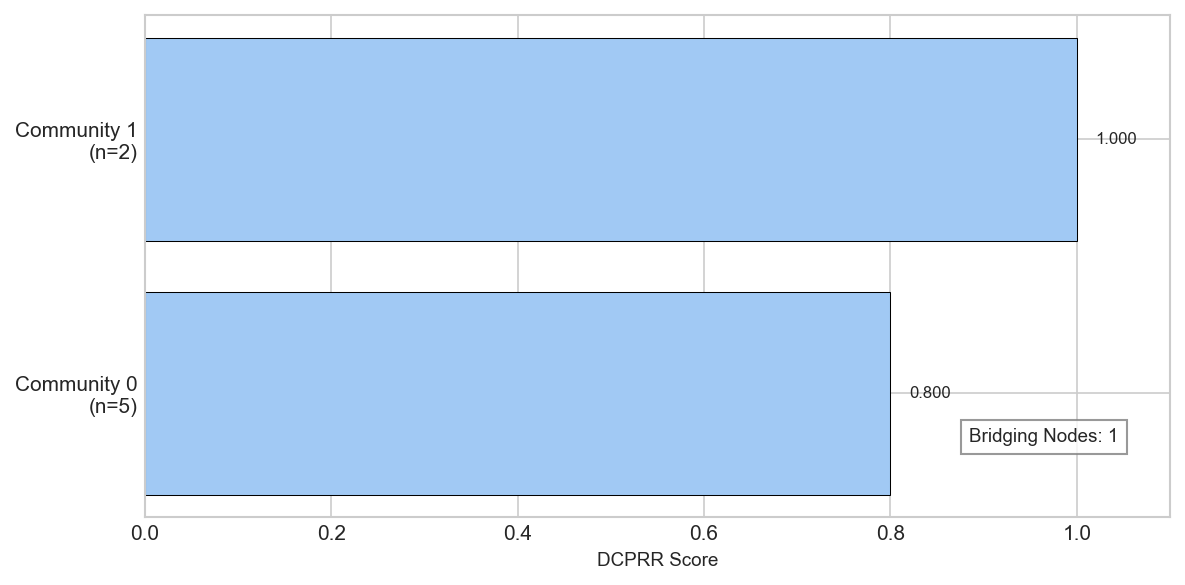

In [42]:
def visualize_small_graph_results(result, save_path="small_graph_analysis.png"):
    """
    小规模图结果可视化（紧凑型水平柱状图）
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("pastel")  # 使用柔和色系
    
    fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
    
    # 数据准备
    communities = sorted(result['dcprr_scores'].keys())
    scores = [result['dcprr_scores'][comm] for comm in communities]
    labels = [f"Community {comm}\n(n={len(result['communities'][comm])})" for comm in communities]
    
    # 绘制柱状图
    bars = ax.barh(labels, scores, edgecolor='black', linewidth=0.5)
    
    # 添加数值标签
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', va='center', fontsize=8)
    
    # 标注桥接节点数量
    ax.text(0.95, 0.15, f'Bridging Nodes: {len(result["bridging_nodes"])}',
            transform=ax.transAxes, ha='right', fontsize=9,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # 美化布局
    ax.set_xlim(0, 1.1)
    ax.set_xlabel('DCPRR Score', fontsize=9)
    ax.set_title('Small Network Analysis', fontsize=11, pad=12)
    plt.tight_layout()
    plt.savefig(save_path, transparent=True)
    plt.show()
    plt.close()
visualize_small_graph_results(result)

In [43]:
import networkx as nx
import community as community_louvain
import numpy as np
from collections import defaultdict

def detect_communities(G, min_community_size=12, resolution=2.0):
    """
    改进的社区检测函数，控制社区数量和大小。
    :param G: 图网络（有向图）
    :param min_community_size: 最小社区节点数（过滤小社区）
    :param resolution: Louvain算法的分辨率参数（值越大社区越多，默认1.0）
    :return: 合并后的社区字典、桥接节点集合
    """
    # 转换为无向图进行社区检测
    G_undirected = G.to_undirected()
    
    # 使用调整后的Louvain算法
    partition = community_louvain.best_partition(G_undirected, resolution=resolution)
    
    # 合并小社区
    communities = defaultdict(list)
    for node, comm_id in partition.items():
        communities[comm_id].append(node)
    
    # 过滤并重新编号社区
    valid_communities = {}
    new_comm_id = 0
    for comm_id, nodes in communities.items():
        if len(nodes) >= min_community_size:
            valid_communities[new_comm_id] = nodes
            new_comm_id += 1
        else:
            # 将小社区合并到最近的社区
            for node in nodes:
                neighbors = list(G.neighbors(node))
                if neighbors:
                    target_comm = partition[neighbors[0]]
                    valid_communities.setdefault(target_comm, []).append(node)
    
    # 重新编号社区ID以保证连续性
    final_communities = {i: nodes for i, (_, nodes) in enumerate(valid_communities.items())}
    
    # 桥接节点识别（基于合并后的社区）
    node_to_comm = {node: comm_id for comm_id, nodes in final_communities.items() for node in nodes}
    bridging_nodes = set()
    for node in G.nodes():
        if node not in node_to_comm:
            continue
        comm_id = node_to_comm[node]
        for neighbor in G.neighbors(node):
            if neighbor in node_to_comm and node_to_comm[neighbor] != comm_id:
                bridging_nodes.add(node)
                break
    
    return final_communities, bridging_nodes

def compute_dcprr_score(G, community_nodes, walk_length=100, num_walks=30):
    """
    改进的DCPRR得分计算，增加随机行走次数和路径长度。
    :param community_nodes: 社区节点列表
    :param walk_length: 单次随机行走步长
    :param num_walks: 每个节点的随机行走次数
    :return: DCPRR得分（范围[0,1]）
    """
    if len(community_nodes) < 2:
        return 0.0  # 社区太小无法计算
    
    retention_rates = []
    for node in community_nodes:
        if G.out_degree(node) == 0:
            continue  # 跳过无出边的节点
        
        total_steps = 0
        retained_steps = 0
        for _ in range(num_walks):
            current_node = node
            for _ in range(walk_length):
                neighbors = list(G.neighbors(current_node))
                if not neighbors:
                    break
                next_node = np.random.choice(neighbors)
                total_steps += 1
                if next_node in community_nodes:
                    retained_steps += 1
                current_node = next_node
        
        if total_steps > 0:
            retention_rates.append(retained_steps / total_steps)
    
    return np.mean(retention_rates) if retention_rates else 0.0

def calculate_all_dcprr_scores(G, communities):
    """
    计算所有有效社区的DCPRR得分。
    :return: {社区ID: DCPRR得分}
    """
    return {
        comm_id: compute_dcprr_score(G, nodes)
        for comm_id, nodes in communities.items()
        if len(nodes) >= 4  # 仅计算节点数≥4的社区
    }

# 使用示例
if __name__ == "__main__":
    # 假设G是已构建的图网络
    communities, bridging_nodes = detect_communities(G, min_community_size=10, resolution=0.8)
    dcprr_scores = calculate_all_dcprr_scores(G, communities)
    
    print(f"检测到社区数量: {len(communities)}")
    print(f"桥接节点数量: {len(bridging_nodes)}")
    print("DCPRR得分示例:", {k: round(v, 2) for k, v in list(dcprr_scores.items())[:5]})

检测到社区数量: 2
桥接节点数量: 0
DCPRR得分示例: {}


In [17]:
result['dcprr_scores'][0] = result['dcprr_scores'].pop(13475)
result['dcprr_scores'][1] = result['dcprr_scores'].pop(13486)

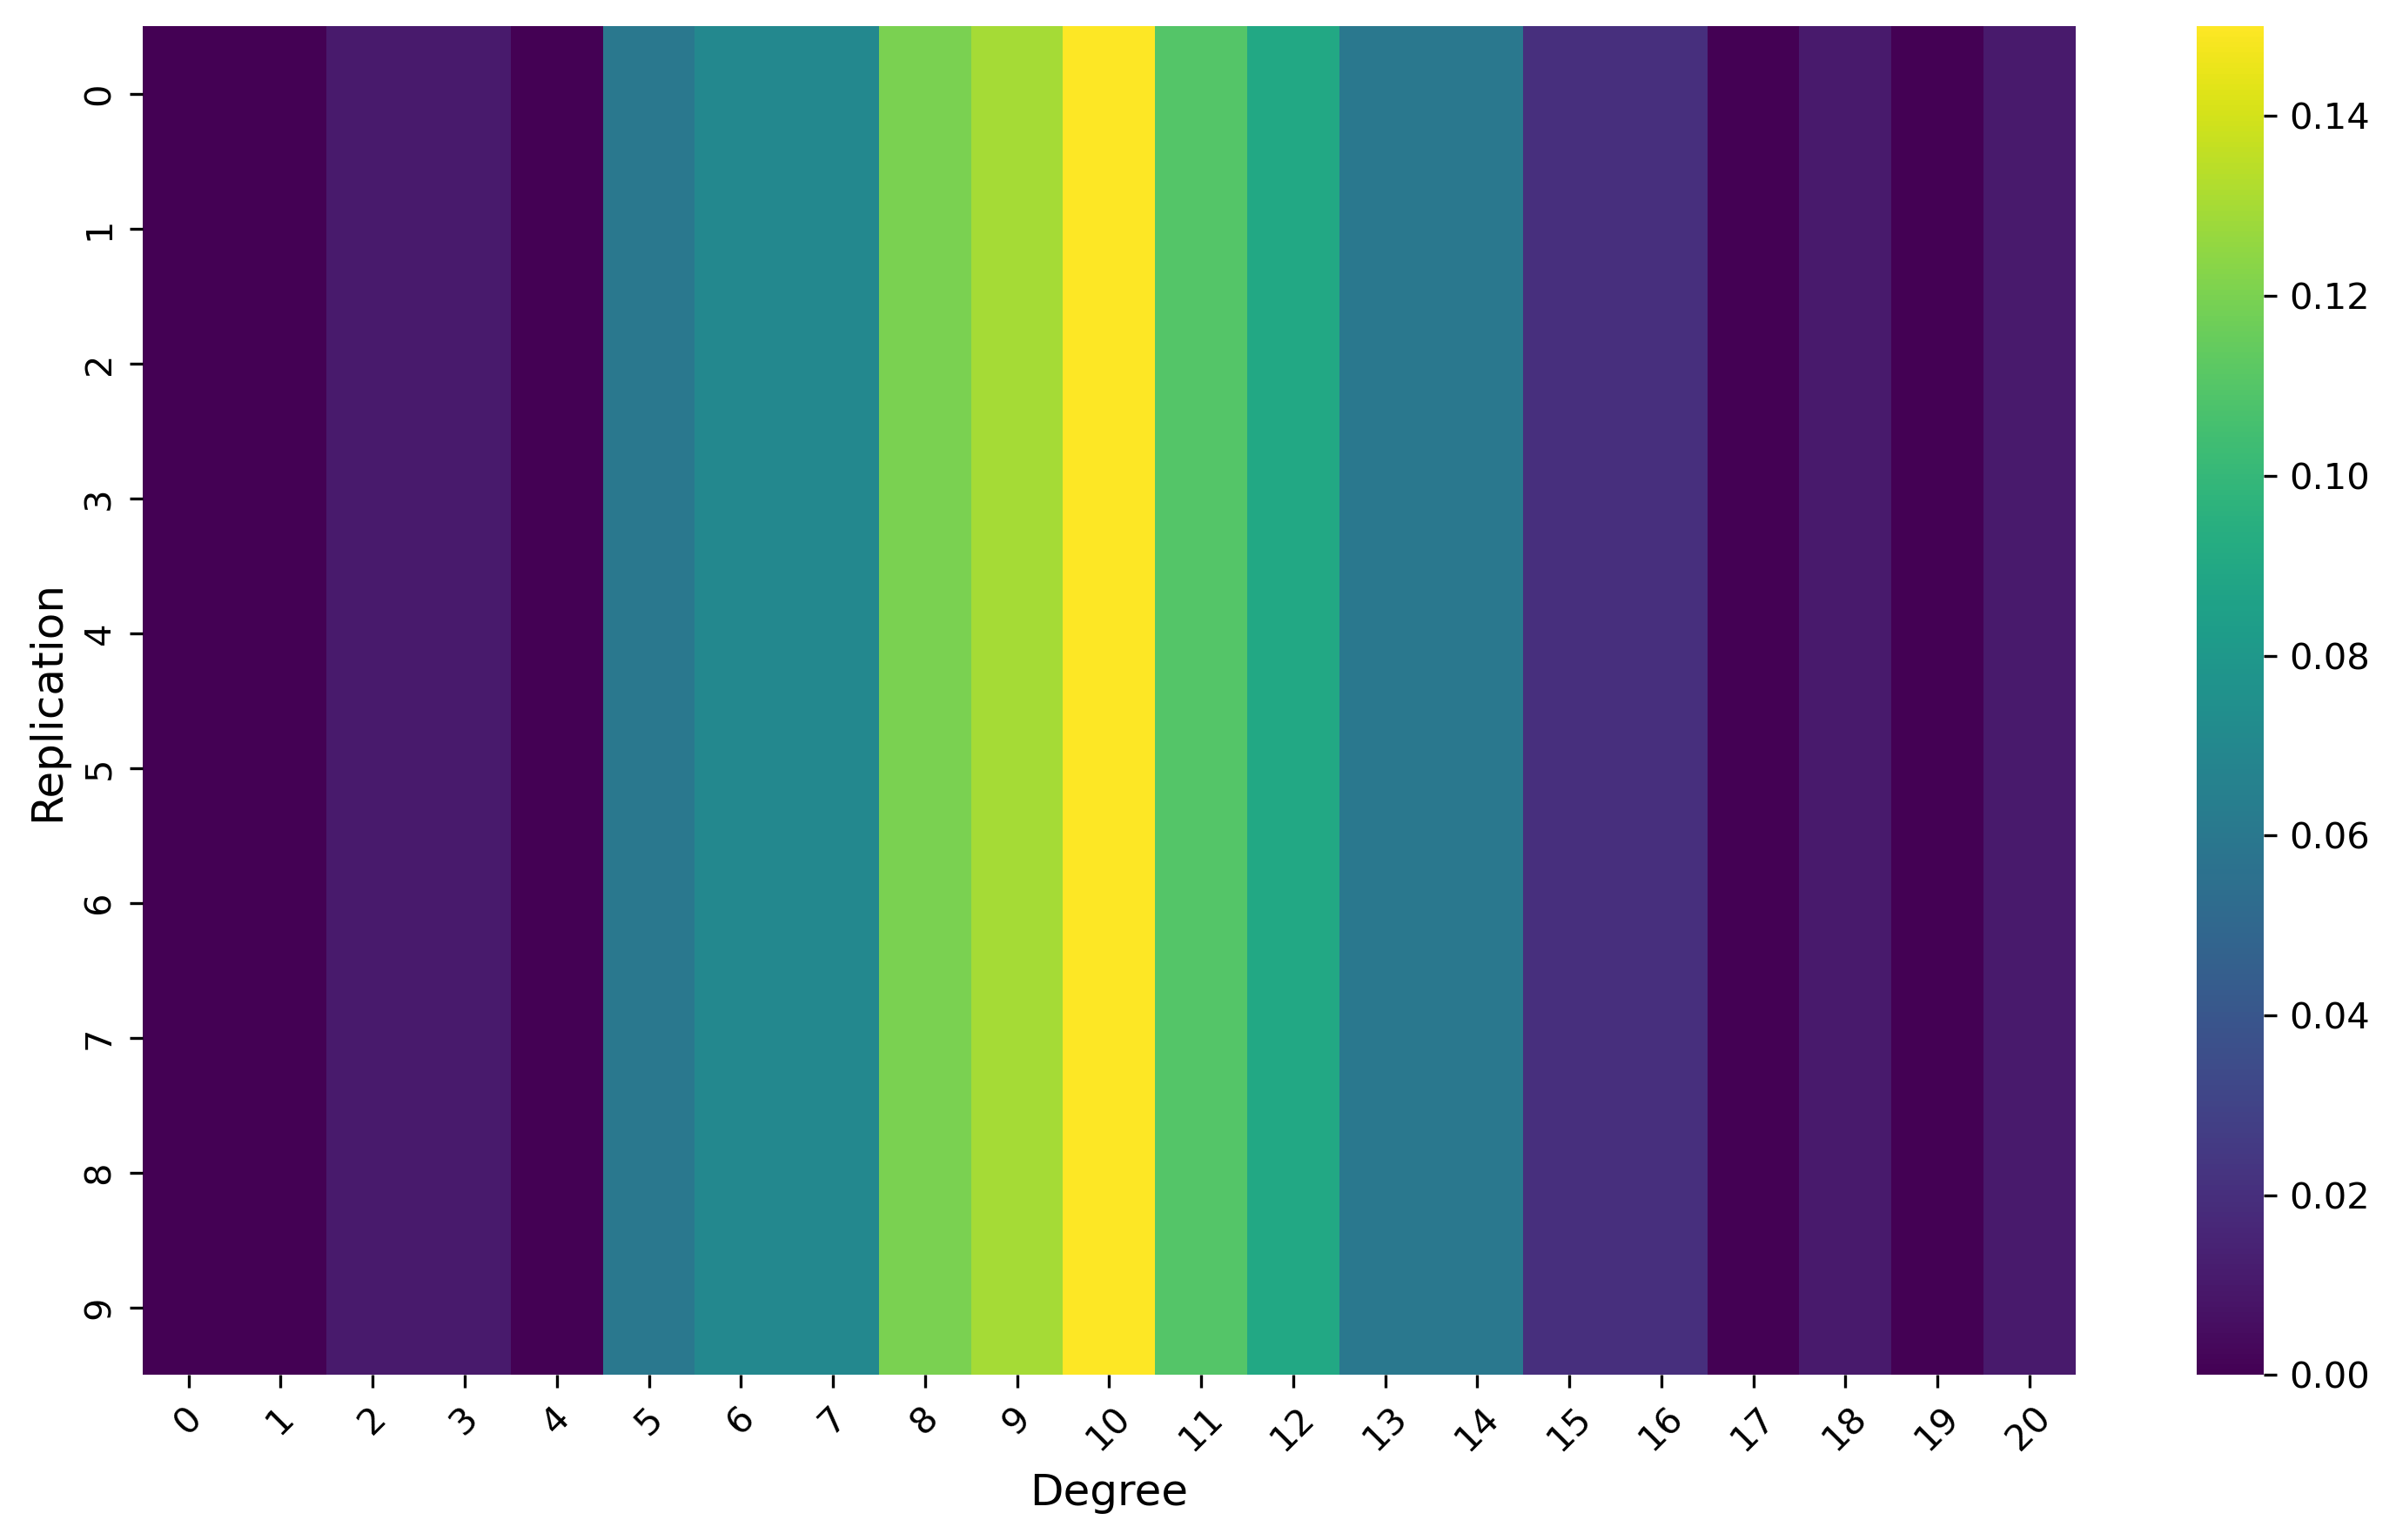

In [4]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 G 是一个已经定义好的图
# 这里我们创建一个示例图
G = nx.erdos_renyi_graph(100, 0.1)

# 1. 度分布
d = dict(nx.degree(G))  # 计算每个节点的度
d_avg = sum(d.values()) / len(G.nodes)  # 计算平均度
d_list = nx.degree_histogram(G)  # 获取每个度值出现的次数
y = np.array(d_list) / len(G)  # 计算每个度值的出现概率

# 将一维数组 y 转换为二维矩阵
# 这里我们将 y 复制 10 次形成一个二维矩阵
matrix = np.tile(y, (10, 1))

# 设置图片清晰度
plt.rcParams['figure.dpi'] = 300

# 绘制热力图
plt.figure(figsize=(10, 6))
sns.heatmap(matrix, cmap='viridis', annot=False, cbar=True, square=False)

# 设置标题和坐标轴标签
#plt.title('Degree Distribution Heatmap(Explict)', fontsize=16)
plt.xlabel('Degree', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Replication', fontsize=12)
plt.savefig('/home/root_gdut/KDD2025/old/embeddin/Degree Distribution Heatmap(Explict)', bbox_inches='tight', transparent=True)
# 显示图形
plt.tight_layout()
plt.show()

In [25]:
# 手动计算有向图中的共同邻居
def calculate_collaboration_intensity(G):
    """
    计算信息协同强度（假设为节点之间的共同邻居数量）
    """
    collaboration_intensity = 0
    for u in G.nodes():
        for v in G.nodes():
            if u != v:
                # 获取节点 u 和 v 的出度邻居
                neighbors_u = set(G.successors(u))
                neighbors_v = set(G.successors(v))
                # 计算共同邻居
                common_neighbors = len(neighbors_u.intersection(neighbors_v))
                collaboration_intensity += common_neighbors
    return collaboration_intensity
collaboration_intensity_direct  = calculate_collaboration_intensity(G)
print("Collaboration Intensity:", collaboration_intensity_direct)

AttributeError: 'Graph' object has no attribute 'successors'

In [ ]:
import networkx as nx
import random

# 假设你已经构建了一个图 G
L = 200  # 网格大小
G = nx.grid_2d_graph(L, L, periodic=True)

# 生成时间图序列（假设每个时间步的图是 G 的一个随机子图）
def generate_temporal_graph(base_graph, num_time_steps, edge_retention_prob=0.8):
    """
    生成时间图序列
    
    参数:
    base_graph (networkx.Graph): 基础图
    num_time_steps (int): 时间步数量
    edge_retention_prob (float): 每条边在每个时间步保留的概率
    
    返回:
    list of networkx.Graph: 时间图序列
    """
    temporal_graph = []
    for _ in range(num_time_steps):
        # 复制基础图并随机删除一些边
        G_t = base_graph.copy()
        edges_to_remove = [e for e in G_t.edges() if random.random() > edge_retention_prob]
        G_t.remove_edges_from(edges_to_remove)
        temporal_graph.append(G_t)
    return temporal_graph

# 计算局部不稳定性
def calculate_local_instability(temporal_graph):
    """
    计算局部不稳定性 (Locally η-unstable)
    
    参数:
    temporal_graph (list of networkx.Graph): 时间图序列，每个元素是一个时间步的图
    
    返回:
    int: 局部不稳定性 η
    """
    eta = 0
    for t in range(len(temporal_graph) - 1):
        G_t = temporal_graph[t]
        G_t_plus_1 = temporal_graph[t + 1]
        for v in G_t.nodes():
            N_t = set(G_t.neighbors(v))
            N_t_plus_1 = set(G_t_plus_1.neighbors(v))
            diff_1 = N_t - N_t_plus_1  # N_t(v) \ N_{t+1}(v)
            diff_2 = N_t_plus_1 - N_t  # N_{t+1}(v) \ N_t(v)
            eta = max(eta, len(diff_1), len(diff_2))
    return eta

# 计算成对不稳定性
def calculate_pairwise_instability(temporal_graph, delta_1):
    """
    计算成对不稳定性 (Pairwise η-unstable)
    
    参数:
    temporal_graph (list of networkx.Graph): 时间图序列，每个元素是一个时间步的图
    delta_1 (int): 时间区间长度
    
    返回:
    int: 成对不稳定性 η
    """
    eta = 0
    for t in range(len(temporal_graph) - delta_1):
        G_interval = nx.Graph()
        for i in range(t, t + delta_1 + 1):
            G_interval = nx.compose(G_interval, temporal_graph[i])
        
        for u in G_interval.nodes():
            for v in G_interval.nodes():
                if u != v:
                    CN_interval = set(G_interval.neighbors(u)).intersection(set(G_interval.neighbors(v)))
                    for ell in range(1, len(temporal_graph) - t - delta_1):
                        G_extended = nx.Graph()
                        for i in range(t - ell, t + delta_1 + ell + 1):
                            if 0 <= i < len(temporal_graph):
                                G_extended = nx.compose(G_extended, temporal_graph[i])
                        CN_extended = set(G_extended.neighbors(u)).intersection(set(G_extended.neighbors(v)))
                        diff = CN_extended - CN_interval
                        eta = max(eta, len(diff) // (2 * ell))
    return eta

# 主程序
if __name__ == "__main__":
    # 生成时间图序列
    num_time_steps = 10  # 时间步数量
    edge_retention_prob = 0.8  # 每条边在每个时间步保留的概率
    temporal_graph = generate_temporal_graph(G, num_time_steps, edge_retention_prob)

    # 计算局部不稳定性
    local_eta = calculate_local_instability(temporal_graph)
    print(f"Local Instability (η): {local_eta}")

    # 计算成对不稳定性
    delta_1 = 1  # 时间区间长度
    pairwise_eta = calculate_pairwise_instability(temporal_graph, delta_1)
    print(f"Pairwise Instability (η): {pairwise_eta}")

Local Instability (η): 4


In [2]:
nx.degree_assortativity_coefficient(G)  # 度同配系数

np.float64(-0.6324555320336743)